In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import sys
import tempfile
import pyabc
import itertools as it

import healpy as hp
from scipy.special import sph_harm
import fitsio
from astropy.coordinates import SkyCoord
import astropy.units as u
import pandas as pd

sys.path.insert(0, '/home/aew492/lss-dipoles/code')
import tools
import dipole
import multipoles
from run_analysis import analyze_Cells
import generate_mocks as gm

## data for Quaia and CatWISE

In [3]:
blim = 30
nside_hi = 64
resdir = '/scratch/aew492/lss-dipoles_results/results'

In [4]:
# expected dipole direction
cmb_dipdir = dipole.cmb_dipole()[1]

In [5]:
# number of sources in each catalog
Nsources = {}

#### Quaia

In [6]:
# selfunc
selfunc_quaia = gm.get_selfunc_map('quaia_G20.0_zodi', nside=nside_hi, blim=blim)
selfunc_quaia_orig = gm.get_selfunc_map('quaia_G20.0_orig', nside=nside_hi, blim=blim)

# load data
# masked
quaia_qmap = np.load(os.path.join(resdir, '../data/catalogs/quaia/quaia_G20.0_masked.npy'))
# the above map smoothed to 1sr
quaia_qmap_smoothed = np.load(os.path.join(resdir, '../data/catalogs/quaia/quaia_G20.0_masked_smoothed_1sr.npy'))
# correct by selfunc
quaia_qmap_corr = quaia_qmap / selfunc_quaia
# load the selfunc-corrected, smoothed map
quaia_qmap_corr_smoothed = np.load(os.path.join(resdir, '../data/catalogs/quaia/quaia_G20.0_masked_corr_smoothed_1sr.npy'))

# base rate for mocks
base_rate_quaia = 33.6330

In [7]:
# add number of sources to dictionary
Nsources['quaia_G20.0_zodi'] = int(np.nansum(quaia_qmap))
Nsources['quaia_G20.0_orig'] = int(np.nansum(quaia_qmap))

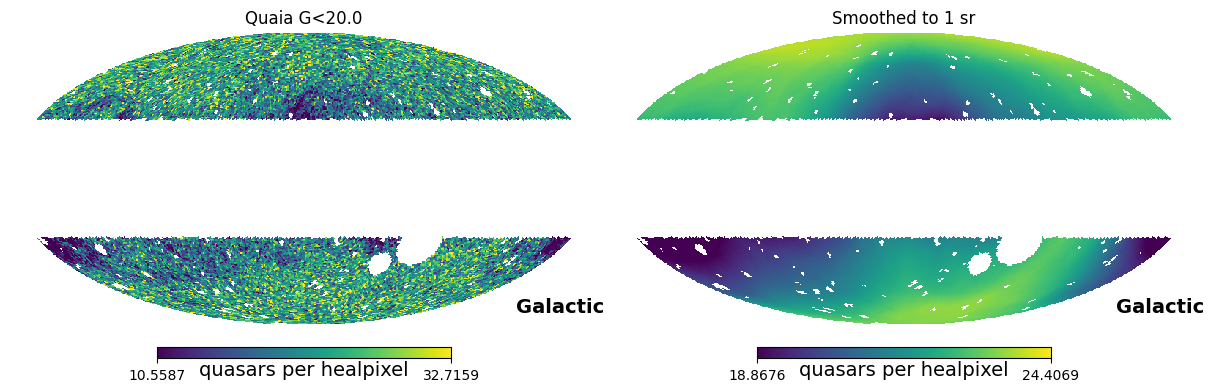

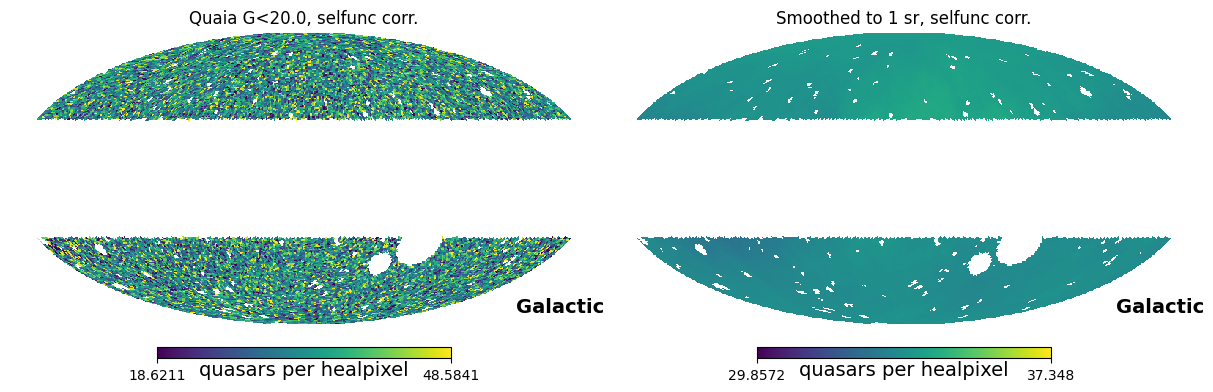

In [8]:
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='viridis', unit='quasars per healpixel', fig=fig, badcolor='w')
mean, std = np.nanmean(quaia_qmap), np.nanstd(quaia_qmap)
hp.mollview(quaia_qmap, min=mean-2*std, max=mean+2*std, title='Quaia G<20.0', sub=(1,2,1), **kwargs)
hp.mollview(quaia_qmap_smoothed, min=mean-0.5*std, max=mean+0.5*std, title='Smoothed to 1 sr', sub=(1,2,2), **kwargs)

fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='viridis', unit='quasars per healpixel', fig=fig, badcolor='w')
mean, std = np.nanmean(quaia_qmap_corr), np.nanstd(quaia_qmap_corr)
hp.mollview(quaia_qmap_corr, min=mean-2*std, max=mean+2*std, title='Quaia G<20.0, selfunc corr.', sub=(1,2,1), **kwargs)
hp.mollview(quaia_qmap_corr_smoothed, min=mean-0.5*std, max=mean+0.5*std, title='Smoothed to 1 sr, selfunc corr.', sub=(1,2,2), **kwargs)

In [9]:
# Quaia G<20.5
selfunc_quaia_205 = gm.get_selfunc_map('quaia_G20.5_orig', nside=nside_hi, blim=blim)
# load catalog
qmap_raw = tools.load_catalog_as_map(f'../data/catalogs/quaia/quaia_G20.5.fits', frame='icrs', nside=nside_hi)
# mask
small_masks = fitsio.read(f'../data/masks/mask_master_hpx_r1.0.fits')
quaia_205 = qmap_raw * small_masks * tools.get_galactic_plane_mask(blim, nside=nside_hi, frame='icrs')
quaia_205[quaia_205 == 0.] = np.nan
# correct by selfunc
quaia_205_corr = quaia_205 / selfunc_quaia_205
# convert to overdensity map
odmap_quaia_205_corr = quaia_205_corr / np.nanmean(quaia_205_corr) - 1

In [10]:
Nsources['quaia_G20.5_orig'] = int(np.nansum(quaia_205))

In [11]:
# zsplits

qmap_raw = tools.load_catalog_as_map(f'../data/catalogs/quaia/quaia_G20.0_zsplit2bin0.fits', frame='icrs', nside=nside_hi)
# mask
small_masks = fitsio.read(f'../data/masks/mask_master_hpx_r1.0.fits')
qmap_masked = qmap_raw * small_masks * tools.get_galactic_plane_mask(blim, nside=nside_hi, frame='icrs')
print(int(np.nansum(qmap_masked)))
Nsources['quaia_G20.0_zsplit2bin0'] = int(np.nansum(qmap_masked))

qmap_raw = tools.load_catalog_as_map(f'../data/catalogs/quaia/quaia_G20.0_zsplit2bin1.fits', frame='icrs', nside=nside_hi)
qmap_masked = qmap_raw * small_masks * tools.get_galactic_plane_mask(blim, nside=nside_hi, frame='icrs')
print(int(np.nansum(qmap_masked)))
Nsources['quaia_G20.0_zsplit2bin1'] = int(np.nansum(qmap_masked))

249455
260298


#### CatWISE

In [12]:
# selfunc
selfunc_catwise_elatcorr = gm.get_selfunc_map('catwise_elatcorr', nside=nside_hi, blim=blim)
selfunc_catwise_zodi = gm.get_selfunc_map('catwise_zodi', nside=nside_hi, blim=blim)
selfunc_catwise = gm.get_selfunc_map('catwise', nside=nside_hi, blim=blim)

# load data
# masked
catwise_qmap = np.load(os.path.join(resdir, '../data/catalogs/catwise_agns/catwise_agns_masked.npy'))
# the above map smoothed to 1sr
catwise_qmap_smoothed = np.load(os.path.join(resdir, '../data/catalogs/catwise_agns/catwise_agns_masked_smoothed_1sr.npy'))
# selfunc-corrected
catwise_qmap_corr_elatcorr = catwise_qmap / selfunc_catwise_elatcorr
catwise_qmap_corr_zodi = catwise_qmap / selfunc_catwise_zodi
# selfunc-corrected and smoothed
catwise_qmap_corr_elatcorr_smoothed = np.load(os.path.join(resdir, '../data/catalogs/catwise_agns/catwise_agns_masked_corr_elatcorr_smoothed_1sr.npy'))
catwise_qmap_corr_zodi_smoothed = np.load(os.path.join(resdir, '../data/catalogs/catwise_agns/catwise_agns_masked_corr_zodi_smoothed_1sr.npy'))

# base rate for mocks
base_rate_catwise = 77.4495

In [13]:
Nsources['catwise_zodi'] = int(np.nansum(catwise_qmap))
Nsources['catwise_elatcorr'] = int(np.nansum(catwise_qmap))

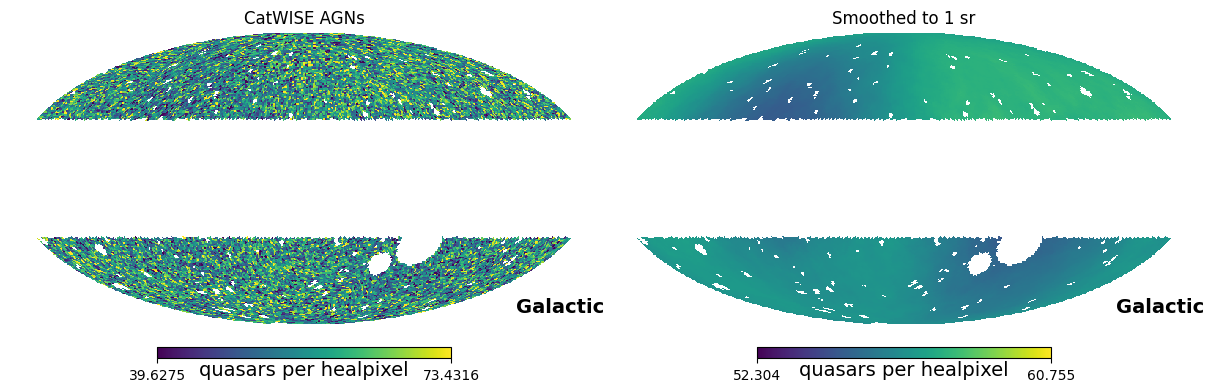

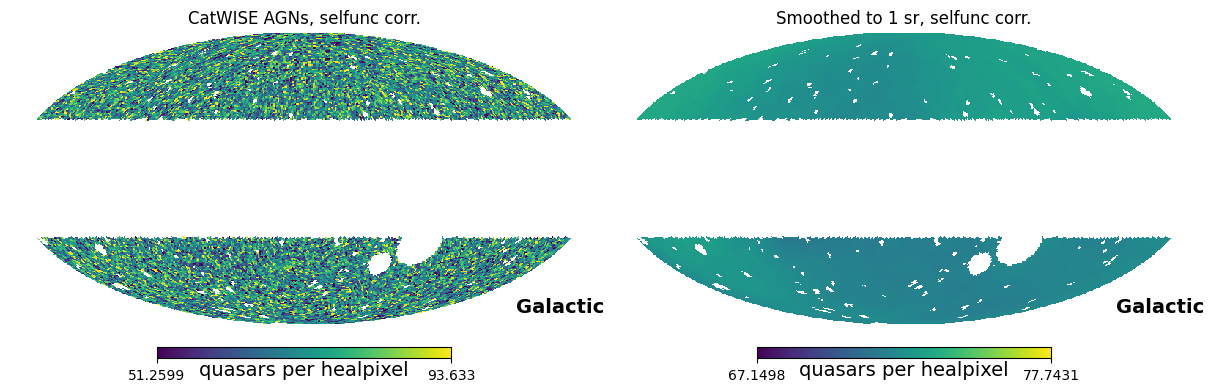

In [14]:
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='viridis', unit='quasars per healpixel', fig=fig, badcolor='w')
mean, std = np.nanmean(catwise_qmap), np.nanstd(catwise_qmap)
hp.mollview(catwise_qmap, min=mean-2*std, max=mean+2*std, title='CatWISE AGNs', sub=(1,2,1), **kwargs)
hp.mollview(catwise_qmap_smoothed, min=mean-0.5*std, max=mean+0.5*std, title='Smoothed to 1 sr', sub=(1,2,2), **kwargs)

fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='viridis', unit='quasars per healpixel', fig=fig, badcolor='w')
mean, std = np.nanmean(catwise_qmap_corr_zodi), np.nanstd(catwise_qmap_corr_zodi)
hp.mollview(catwise_qmap_corr_zodi, min=mean-2*std, max=mean+2*std, title='CatWISE AGNs, selfunc corr.', sub=(1,2,1), **kwargs)
hp.mollview(catwise_qmap_corr_zodi_smoothed, min=mean-0.5*std, max=mean+0.5*std, title='Smoothed to 1 sr, selfunc corr.', sub=(1,2,2), **kwargs)

#### selection function plots

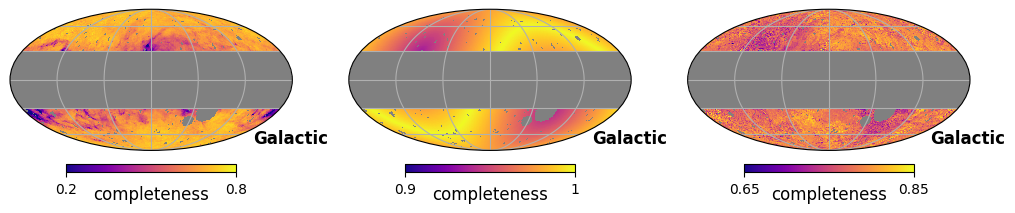

In [15]:
# plot
fig = plt.figure(figsize=(10,3))
kwargs = dict(coord=['C','G'], cmap='plasma', unit='completeness', fig=fig, graticule=True)#, badcolor='w')
selfunc_quaia_ = np.copy(selfunc_quaia)
selfunc_quaia_[selfunc_quaia <= 0.] = np.nan
selfunc_catwise_ = np.copy(selfunc_catwise_zodi)
selfunc_catwise_[selfunc_catwise_zodi <= 0.] = np.nan
selfunc_catwise_elatcorr_ = np.copy(selfunc_catwise_elatcorr)
selfunc_catwise_elatcorr_[selfunc_catwise_elatcorr_ <= 0.] = np.nan
hp.projview(selfunc_quaia_, title='', min=0.2, max=0.8, sub=(1,3,1), **kwargs)
tools.label_coord('Galactic', fs=12)
hp.projview(selfunc_catwise_elatcorr_, title='', min=0.9, max=1., sub=(1,3,2), **kwargs)
tools.label_coord('Galactic', fs=12)
hp.projview(selfunc_catwise_, title='', min=0.65, max=0.85, sub=(1,3,3), **kwargs)
tools.label_coord('Galactic', fs=12)

/state/partition1/job-61474521/ipykernel_2465577/2410874071.py:2: RuntimeWarning: invalid value encountered in divide
  hp.mollview(selfunc_quaia / selfunc_quaia_orig, sub=(1,2,1), min=0.9, max=1.1,


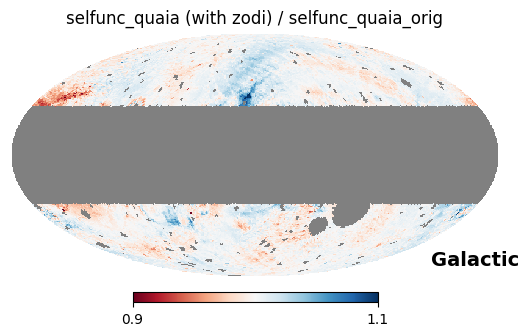

In [20]:
fig = plt.figure(figsize=(10,3))
hp.mollview(selfunc_quaia / selfunc_quaia_orig, sub=(1,2,1), min=0.9, max=1.1,
            title='selfunc_quaia (with zodi) / selfunc_quaia_orig', coord=['C','G'], cmap='RdBu')

In [16]:
# nside for results
nside = 2

## ABC results: free dipole

In [21]:
def get_abc_results_free_dipole(fn, xticks=None, title=None):

    res = np.load(fn, allow_pickle=True).item()
    history = res['history']
    prior = res['prior']
    posterior = res['posterior']
    selfunc = res['selfunc']
    expected_dipamp = res['expected_dipole_amp']

    par_ids = [x for x in prior.keys()]
    fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(10,8), tight_layout=True)
    labels = [r'$|\vec{\mathcal{D}}_x|$', r'$|\vec{\mathcal{D}}_y|$', r'$|\vec{\mathcal{D}}_z|$']  # bug: these labels are hard-coded

    df, w = posterior

    # quantiles
    qs = [
        tools.quantile(df[par_id], [0.16, 0.5, 0.84], weights=w) for x in ['dipole_x', 'dipole_y', 'dipole_z']
    ]

    for i, par_id in enumerate(par_ids):

        # quantile
        q = qs[i]
        
        # diagonal
        ax = axs[i, i]
        ax.axvline(q[1], c='k', alpha=0.4, ls='-', label='Median')
        ax.axvspan(q[0], q[2], color='k', alpha=0.05)
        ax.axhline(0., c='k', alpha=0.5, lw=0.5)
        ax.grid(alpha=0.5, lw=0.5)
        ax.set_xlim(prior[par_id].args[0], prior[par_id].args[0] + prior[par_id].args[1])
        if xticks is not None:
            ax.set_xticks(xticks)
        ax.axvline(0., c='k', alpha=0.5, lw=0.5)
        
        x, pdf = tools.get_kde_1d([df, w], prior, par_id)
        ax.plot(x, pdf, c='k', alpha=0.9, lw=1.5)

        axs[i,0].set_ylabel(labels[i], fontsize=12)
        axs[len(par_ids)-1,i].set_xlabel(labels[i], fontsize=12)

        for j in range(0, i):
    
            # lower
            ax = axs[i, j]
            x, y, pdf = tools.get_kde_2d([df, w], prior, par_ids[j], par_id)
            mesh = ax.pcolormesh(x, y, pdf, shading='auto', cmap='binary')
    
            # upper
            ax = axs[j, i]
            tools.scatter([df, w], prior, par_id, par_ids[j], ax, color='k', alpha=0.5, marker='.', s=3)
            ax.grid(alpha=0.5, lw=0.5)
        
    if title is not None:
        fig.suptitle(title)

    return qs, res, axs

### Quaia G20.0

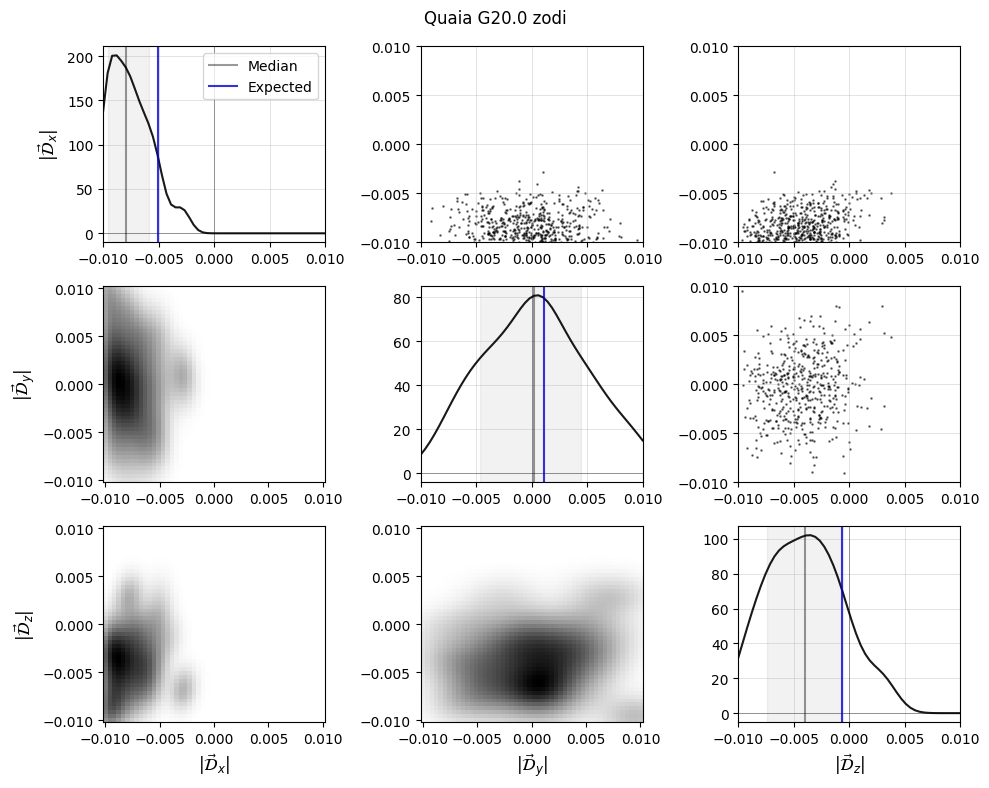

In [20]:
sample_name = 'quaia_G20.0_zodi'
qs, res, axs = get_abc_results_free_dipole(os.path.join(resdir,
                            f'ABC/{sample_name}_free_dipole_nside{nside}_500mocks_14iters_base-rate-{base_rate_quaia:.4f}/results.npy'),
                                          title='Quaia G20.0 zodi')
# expected dipole
expected_dipamp = 0.0052
expected_dipdir = SkyCoord(264, 48, unit=u.deg, frame='galactic')
comps = tools.spherical_to_cartesian(r=expected_dipamp, theta=np.pi/2-expected_dipdir.icrs.dec.rad, phi=expected_dipdir.icrs.ra.rad)
for i, comp in enumerate(comps):
    axs[i,i].axvline(comp, c='mediumblue', alpha=0.8, label='Expected')
axs[0,0].legend()

## ABC results: free `dipole_amp` only

In [24]:
def get_abc_results_dipole_only(fn, xticks=None, title=None):

    res = np.load(fn, allow_pickle=True).item()
    history = res['history']
    prior = res['prior']
    posterior = res['posterior']
    selfunc = res['selfunc']
    expected_dipamp = res['expected_dipole_amp']
    print(f"expected dipole_amp = {expected_dipamp}")
    
    # quantiles
    df, w = posterior
    q_dipamp = tools.quantile(df['dipole_amp'], [0.16, 0.5, 0.84], weights=w)

    # calculate the sigma discrepancy: ****check with Kate and Hogg: is this the right way to do this?
    # z score is z = (x_0 - \mu) / \sigma , where x_0 is the null hypothesis, \mu is mean (or MAP? or median?)
    #    and \sigma = std. of the posterior
    
    # how different is the mean from the median?
    print(f"mean dipole_amp = {pyabc.weighted_statistics.weighted_mean(df['dipole_amp'], w):.4f}")
    print(f"median dipole_amp = {q_dipamp[1]:.4f}")
    mu = q_dipamp[1]
    
    # standard deviation
    sigma = pyabc.weighted_statistics.weighted_std(df['dipole_amp'], w)
    print(f"std dipole_amp = {sigma:.4f}")

    relamp = np.array(q_dipamp) / expected_dipamp
    
    # z score
    z = (expected_dipamp - mu) / sigma
    print(f"z score = {z:.4f}")

    # plot (copied and adjusted from the pyabc.visualization source code)
    par_id = [x for x in prior.keys()][0]
    fig, ax = plt.subplots(figsize=(5,4), tight_layout=True)
    label = 'Dipole amplitude in CMB dir.'
    
    df, w = posterior
    
    # quantiles?
    q = tools.quantile(df[par_id], [0.16, 0.5, 0.84], weights=w)
    
    # diagonal
    ax.axvline(q[1], c='k', alpha=0.4, ls='-', label='Median')
    ax.axvspan(q[0], q[2], color='k', alpha=0.05)
    ax.axhline(0., c='k', alpha=0.5, lw=0.5)
    ax.axvline(expected_dipamp, c='crimson', alpha=0.8, lw=1.5, label='Expected')
    ax.legend()
    ax.grid(alpha=0.5, lw=0.5)
    ax.set_xlim(prior[par_id].args[0], prior[par_id].args[0] + prior[par_id].args[1])
    if xticks is not None:
        ax.set_xticks(xticks)
    ax.axvline(0., c='k', alpha=0.5, lw=0.5)
    
    x, pdf = tools.get_kde_1d([df, w], prior, par_id)
    ax.plot(x, pdf, c='k', alpha=0.9, lw=1.5)
    
    ax.set_ylabel(label)
    ax.set_xlabel(label)

    if title is not None:
        ax.set_title(title)

    return q_dipamp, relamp, z, res

In [25]:
sample_names = []
quantiles = []
relamps = []
zscores = []
ress = []

### Quaia

expected dipole_amp = 0.0052
mean dipole_amp = 0.0088
median dipole_amp = 0.0088
std dipole_amp = 0.0024
z score = -1.5129


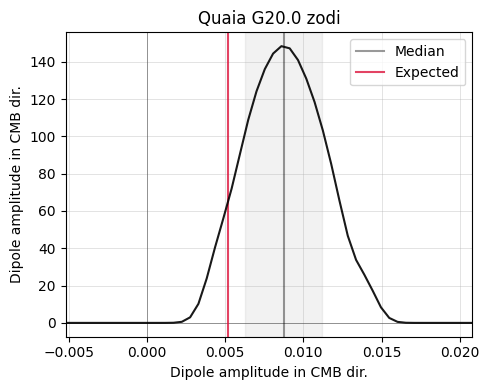

In [26]:
sample_name = 'quaia_G20.0_zodi'
q, relamp, z, res = get_abc_results_dipole_only(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_only_nside{nside}_500mocks_18iters_base-rate-{base_rate_quaia:.4f}/results.npy'),
                                          title='Quaia G20.0 zodi')
sample_names.append(sample_name)
quantiles.append(q)
relamps.append(relamp)
zscores.append(z)
ress.append(res)

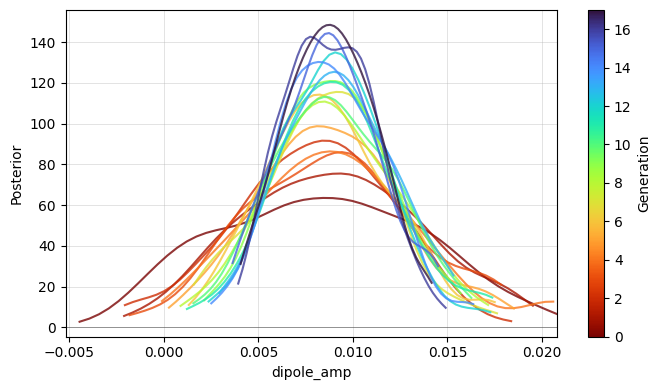

In [27]:
# evolution of the posterior
fig, ax = plt.subplots(figsize=(7,4), tight_layout=True)
norm = mpl.colors.Normalize(vmin=0, vmax=res['history'].max_t)
smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo_r')

par_id = 'dipole_amp'

for i in range(res['history'].max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(res['history'], par_id, t=i, ax=ax, color=smap.to_rgba(i), alpha=0.8)
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(par_id)
ax.set_xlim(res['prior'][par_id].args[0], res['prior'][par_id].args[0] + res['prior'][par_id].args[1])
# ax.set_xlim(prior[par_id][0])
ax.axhline(0., c='k', alpha=0.5, lw=0.5)
fig.colorbar(smap, ax=ax, label='Generation')

expected dipole_amp = 0.0052
mean dipole_amp = 0.0100
median dipole_amp = 0.0101
std dipole_amp = 0.0029
z score = -1.7052


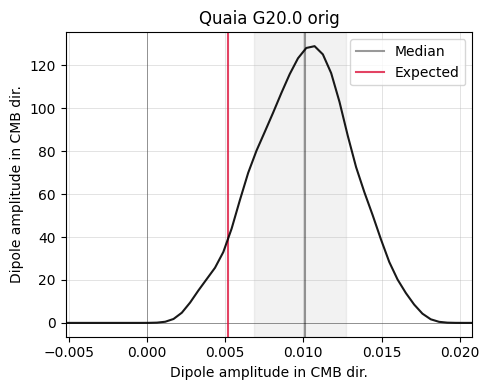

In [28]:
sample_name = 'quaia_G20.0_orig'
q, relamp, z, res = get_abc_results_dipole_only(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_only_nside{nside}_500mocks_18iters_base-rate-{base_rate_quaia:.4f}/results.npy'),
                                          title='Quaia G20.0 orig')
sample_names.append(sample_name)
quantiles.append(q)
relamps.append(relamp)
zscores.append(z)
ress.append(res)

expected dipole_amp = 0.0047
mean dipole_amp = 0.0126
median dipole_amp = 0.0125
std dipole_amp = 0.0025
z score = -3.1497


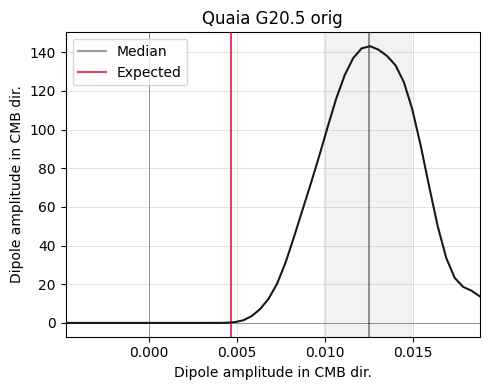

In [29]:
sample_name = 'quaia_G20.5_orig'
q, relamp, z, res = get_abc_results_dipole_only(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_only_nside{nside}_500mocks_18iters_base-rate-{41.3560:.4f}/results.npy'),
                                          title='Quaia G20.5 orig')
sample_names.append(sample_name)
quantiles.append(q)
relamps.append(relamp)
zscores.append(z)
ress.append(res)

expected dipole_amp = 0.005
mean dipole_amp = 0.0105
median dipole_amp = 0.0110
std dipole_amp = 0.0030
z score = -1.9801


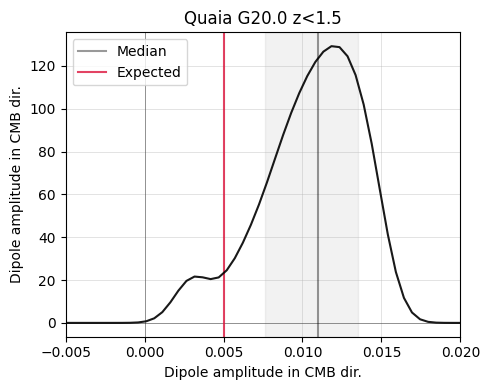

In [30]:
sample_name = 'quaia_G20.0_zsplit2bin0'
q, relamp, z, res = get_abc_results_dipole_only(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_only_nside{nside}_500mocks_18iters_base-rate-{18.0810:.4f}/results.npy'),
                                          title='Quaia G20.0 z<1.5')
sample_names.append(sample_name)
quantiles.append(q)
relamps.append(relamp)
zscores.append(z)
ress.append(res)

expected dipole_amp = 0.0055
mean dipole_amp = 0.0111
median dipole_amp = 0.0109
std dipole_amp = 0.0035
z score = -1.5508


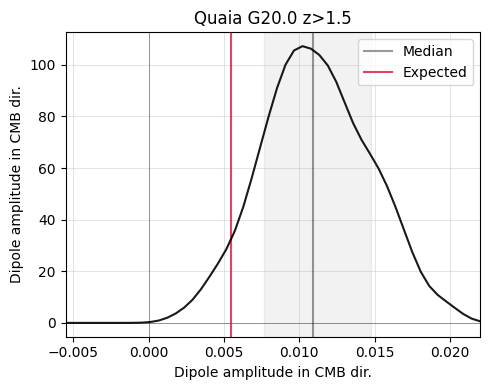

In [31]:
sample_name = 'quaia_G20.0_zsplit2bin1'
q, relamp, z, res = get_abc_results_dipole_only(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_only_nside{nside}_500mocks_18iters_base-rate-{18.840:.4f}/results.npy'),
                                          title='Quaia G20.0 z>1.5')
sample_names.append(sample_name)
quantiles.append(q)
relamps.append(relamp)
zscores.append(z)
ress.append(res)

### CatWISE

expected dipole_amp = 0.0074
mean dipole_amp = 0.0090
median dipole_amp = 0.0090
std dipole_amp = 0.0019
z score = -0.8677


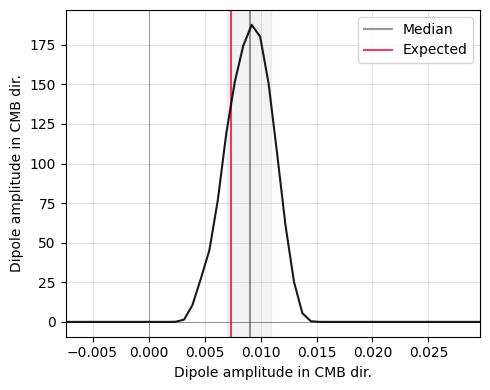

In [32]:
sample_name = 'catwise_zodi'
q, relamp, z, res = get_abc_results_dipole_only(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_only_nside{nside}_500mocks_18iters_base-rate-{base_rate_catwise:.4f}/results.npy'))
sample_names.append(sample_name)
quantiles.append(q)
relamps.append(relamp)
zscores.append(z)
ress.append(res)

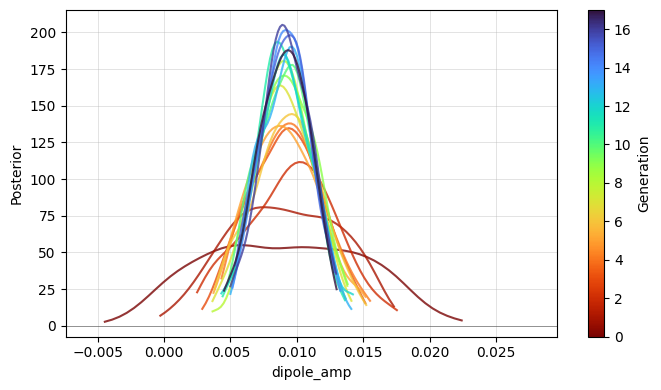

In [33]:
# evolution of the posterior
fig, ax = plt.subplots(figsize=(7,4), tight_layout=True)
norm = mpl.colors.Normalize(vmin=0, vmax=res['history'].max_t)
smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo_r')

par_id = 'dipole_amp'

for i in range(res['history'].max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(res['history'], par_id, t=i, ax=ax, color=smap.to_rgba(i), alpha=0.8)
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(par_id)
ax.set_xlim(res['prior'][par_id].args[0], res['prior'][par_id].args[0] + res['prior'][par_id].args[1])
# ax.set_xlim(prior[par_id][0])
ax.axhline(0., c='k', alpha=0.5, lw=0.5)
fig.colorbar(smap, ax=ax, label='Generation')

expected dipole_amp = 0.0074
mean dipole_amp = 0.0120
median dipole_amp = 0.0120
std dipole_amp = 0.0019
z score = -2.4360


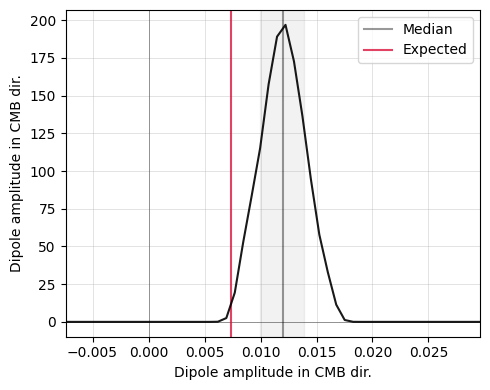

In [34]:
sample_name = 'catwise_elatcorr'
q, relamp, z, res = get_abc_results_dipole_only(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_only_nside{nside}_500mocks_18iters_base-rate-{base_rate_catwise:.4f}/results.npy'))
sample_names.append(sample_name)
quantiles.append(q)
relamps.append(relamp)
zscores.append(z)
ress.append(res)

In [35]:
print(f"{'sample name:':30}{'dipole posterior:':30}{'relative amplitude:':25}{'z score:'}")
print('=' * 110)
for i, (name, quantile, relamp, zscore) in enumerate(zip(sample_names, quantiles, relamps, zscores)):
    q_str = f'{quantile[1]:.4f} +{quantile[2]-quantile[1]:.4f} -{quantile[1]-quantile[0]:.4f}'
    relamp_str = f'{relamp[1]:.3f} +{relamp[2]-relamp[1]:.3f} -{relamp[1]-relamp[0]:.3f}'
    print(f"{name:30}{q_str:30}{relamp_str:25}{zscore:.3f}")

sample name:                  dipole posterior:             relative amplitude:      z score:
quaia_G20.0_zodi              0.0088 +0.0024 -0.0025        1.690 +0.461 -0.479      -1.513
quaia_G20.0_orig              0.0101 +0.0026 -0.0032        1.947 +0.496 -0.625      -1.705
quaia_G20.5_orig              0.0125 +0.0024 -0.0025        2.660 +0.510 -0.540      -3.150
quaia_G20.0_zsplit2bin0       0.0110 +0.0025 -0.0034        2.203 +0.498 -0.681      -1.980
quaia_G20.0_zsplit2bin1       0.0109 +0.0039 -0.0033        1.988 +0.702 -0.595      -1.551
catwise_zodi                  0.0090 +0.0019 -0.0021        1.222 +0.256 -0.279      -0.868
catwise_elatcorr              0.0120 +0.0019 -0.0020        1.618 +0.262 -0.271      -2.436


In [36]:
# save the relative amplitudes for the summary plot
sample_names_dipole_only = sample_names
relamps_dipole_only = relamps

## `dipole_amp` and `log_excess` parameters

In [37]:
def get_abc_results_dipole_excess(fn, xticks=None, title=None):

    res = np.load(fn, allow_pickle=True).item()
    history = res['history']
    prior = res['prior']
    posterior = res['posterior']
    selfunc = res['selfunc']
    expected_dipamp = res['expected_dipole_amp']
    print(f"expected dipole_amp = {expected_dipamp}")
    
    # quantiles
    df, w = posterior
    q_dipamp = tools.quantile(df['dipole_amp'], [0.16, 0.5, 0.84], weights=w)
    q_excess = tools.quantile(df['log_excess'], [0.16, 0.5, 0.84], weights=w)

    # calculate the sigma discrepancy: ****check with Kate and Hogg: is this the right way to do this?
    # z score is z = (x_0 - \mu) / \sigma , where x_0 is the null hypothesis, \mu is mean (or MAP? or median?)
    #    and \sigma = std. of the posterior
    
    # how different is the mean from the median?
    print(f"mean dipole_amp = {pyabc.weighted_statistics.weighted_mean(df['dipole_amp'], w):.4f}")
    print(f"median dipole_amp = {q_dipamp[1]:.4f}")
    mu = q_dipamp[1]
    
    # standard deviation
    sigma = pyabc.weighted_statistics.weighted_std(df['dipole_amp'], w)
    print(f"std dipole_amp = {sigma:.4f}")

    relamp = np.array(q_dipamp) / expected_dipamp
    
    # z score
    z = (expected_dipamp - mu) / sigma
    print(f"z score = {z:.4f}")

    # plot (copied and adjusted from the pyabc.visualization source code)
    par_id = [x for x in prior.keys()][0]
    fig, axs = plt.subplots(2, 2, figsize=(7,6), tight_layout=True)
    
    df, w = posterior

    par_ids = [x for x in prior.keys()]
    labels = [r'$|\vec{\mathcal{D}}_{\mathrm{proj},k}|$', r'$\log \bar C$']  # bug: these labels are hard-coded

    for i, par_id in enumerate(par_ids):
    
        # quantiles?
        q = tools.quantile(df[par_id], [0.16, 0.5, 0.84], weights=w)
        
        # diagonal
        ax = axs[i, i]
        ax.axvline(q[1], c='k', alpha=0.4, ls='-', label='Median')
        ax.axvspan(q[0], q[2], color='k', alpha=0.05)
        ax.axhline(0., c='k', alpha=0.5, lw=0.5)
        if i == 0:
            ax.axvline(expected_dipamp, c='crimson', alpha=0.8, lw=1.5, label='Expected')
            ax.legend()
        ax.grid(alpha=0.5, lw=0.5)
        ax.set_xlim(prior[par_id].args[0], prior[par_id].args[0] + prior[par_id].args[1])
        if xticks is not None:
            ax.set_xticks(xticks)
        ax.axvline(0., c='k', alpha=0.5, lw=0.5)
        
        x, pdf = tools.get_kde_1d([df, w], prior, par_id)
        ax.plot(x, pdf, c='k', alpha=0.9, lw=1.5)

        axs[i,0].set_ylabel(labels[i], fontsize=12)
        axs[len(par_ids)-1,i].set_xlabel(labels[i], fontsize=12)

        for j in range(0, i):
    
            # lower
            ax = axs[i, j]
            x, y, pdf = tools.get_kde_2d([df, w], prior, par_ids[j], par_id)
            mesh = ax.pcolormesh(x, y, pdf, shading='auto', cmap='binary')
    
            # upper
            ax = axs[j, i]
            tools.scatter([df, w], prior, par_id, par_ids[j], ax, color='k', alpha=0.5, marker='.', s=3)
            ax.grid(alpha=0.5, lw=0.5)
    
    if title is not None:
        fig.suptitle(title)
    
    return q_dipamp, q_excess, relamp, z, res, axs

In [38]:
sample_names = []
quantiles_amp = []
quantiles_excess = []
relamps = []
zscores = []

expected dipole_amp = 0.0052
mean dipole_amp = 0.0088
median dipole_amp = 0.0087
std dipole_amp = 0.0026
z score = -1.3762


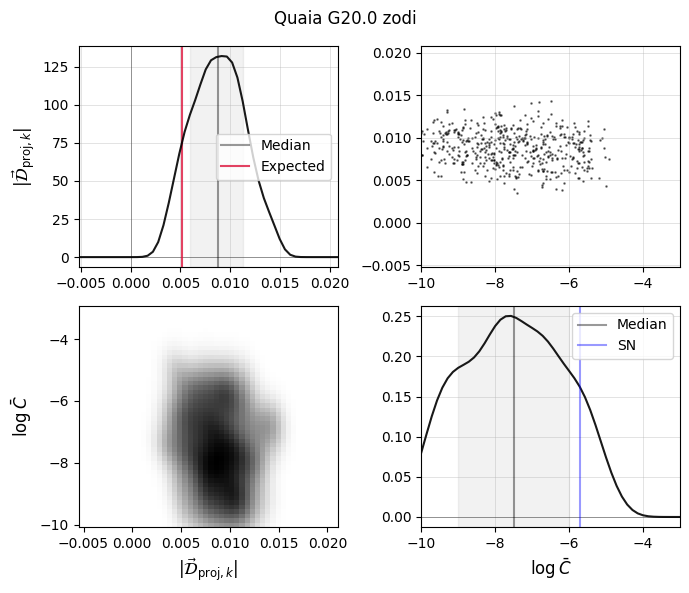

In [39]:
sample_name = 'quaia_G20.0_zodi'
q_amp, q_excess, relamp, z, res, axs = get_abc_results_dipole_excess(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_excess_nside{nside}_500mocks_18iters_base-rate-{base_rate_quaia:.4f}/results.npy'),
                                          title='Quaia G20.0 zodi')
axs[1,1].axvline(np.log10(1/Nsources[sample_name]), c='b', alpha=0.4, lw=1.5, label='SN')
axs[1,1].legend()
sample_names.append(sample_name)
quantiles_amp.append(q_amp)
quantiles_excess.append(q_excess)
relamps.append(relamp)
zscores.append(z)

expected dipole_amp = 0.0052
mean dipole_amp = 0.0097
median dipole_amp = 0.0095
std dipole_amp = 0.0025
z score = -1.7041


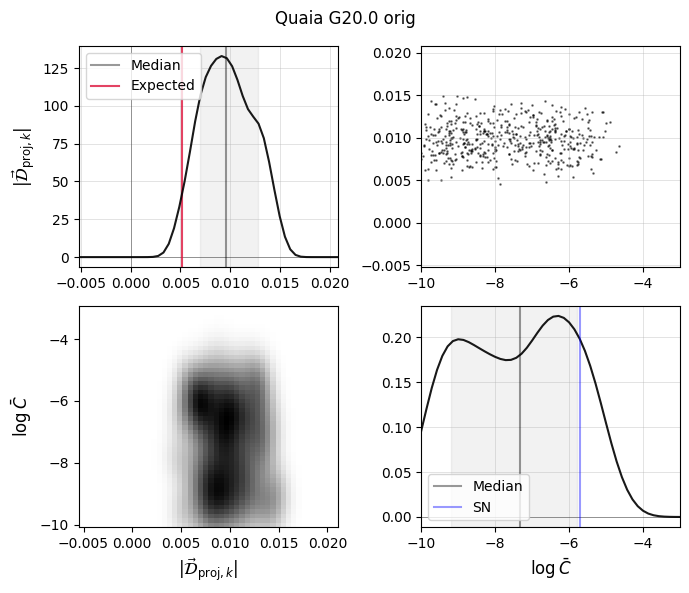

In [40]:
sample_name = 'quaia_G20.0_orig'
q_amp, q_excess, relamp, z, res, axs = get_abc_results_dipole_excess(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_excess_nside{nside}_500mocks_18iters_base-rate-{base_rate_quaia:.4f}/results.npy'),
                                          title='Quaia G20.0 orig')
axs[1,1].axvline(np.log10(1/Nsources[sample_name]), c='b', alpha=0.4, lw=1.5, label='SN')
axs[1,1].legend()
sample_names.append(sample_name)
quantiles_amp.append(q_amp)
quantiles_excess.append(q_excess)
relamps.append(relamp)
zscores.append(z)

expected dipole_amp = 0.0047
mean dipole_amp = 0.0127
median dipole_amp = 0.0127
std dipole_amp = 0.0026
z score = -3.0662


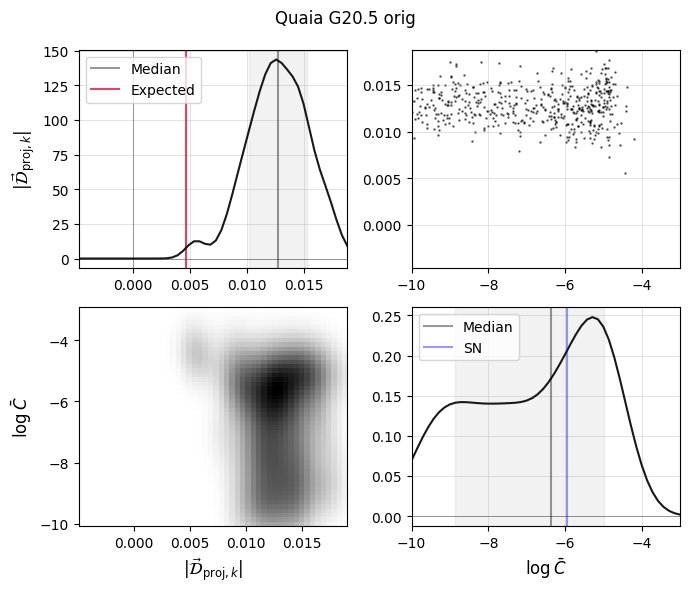

In [41]:
sample_name = 'quaia_G20.5_orig'
q_amp, q_excess, relamp, z, res, axs = get_abc_results_dipole_excess(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_excess_nside{nside}_500mocks_18iters_base-rate-{41.3560:.4f}/results.npy'),
                                          title='Quaia G20.5 orig')
axs[1,1].axvline(np.log10(1/Nsources[sample_name]), c='b', alpha=0.4, lw=1.5, label='SN')
axs[1,1].legend()
sample_names.append(sample_name)
quantiles_amp.append(q_amp)
quantiles_excess.append(q_excess)
relamps.append(relamp)
zscores.append(z)

expected dipole_amp = 0.005
mean dipole_amp = 0.0124
median dipole_amp = 0.0124
std dipole_amp = 0.0033
z score = -2.2212


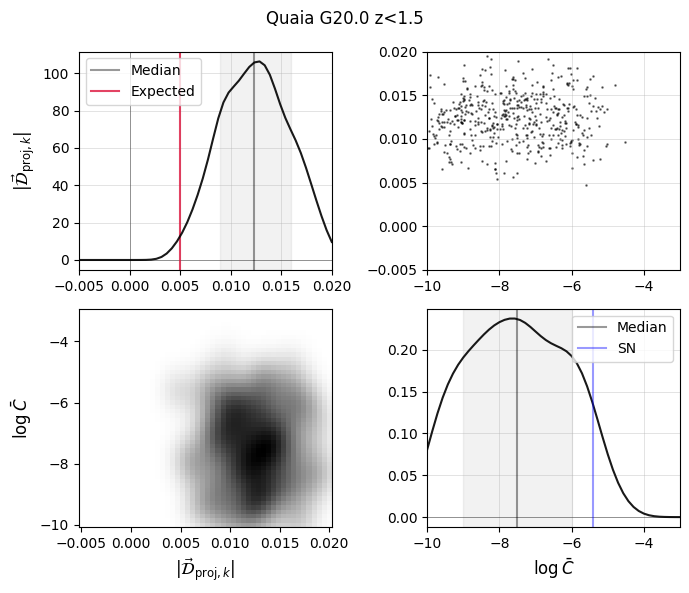

In [42]:
sample_name = 'quaia_G20.0_zsplit2bin0'
q_amp, q_excess, relamp, z, res, axs = get_abc_results_dipole_excess(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_excess_nside{nside}_500mocks_18iters_base-rate-{18.0810:.4f}/results.npy'),
                                          title='Quaia G20.0 z<1.5')
axs[1,1].axvline(np.log10(1/Nsources[sample_name]), c='b', alpha=0.4, lw=1.5, label='SN')
axs[1,1].legend()
sample_names.append(sample_name)
quantiles_amp.append(q_amp)
quantiles_excess.append(q_excess)
relamps.append(relamp)
zscores.append(z)

expected dipole_amp = 0.0055
mean dipole_amp = 0.0111
median dipole_amp = 0.0111
std dipole_amp = 0.0038
z score = -1.4891


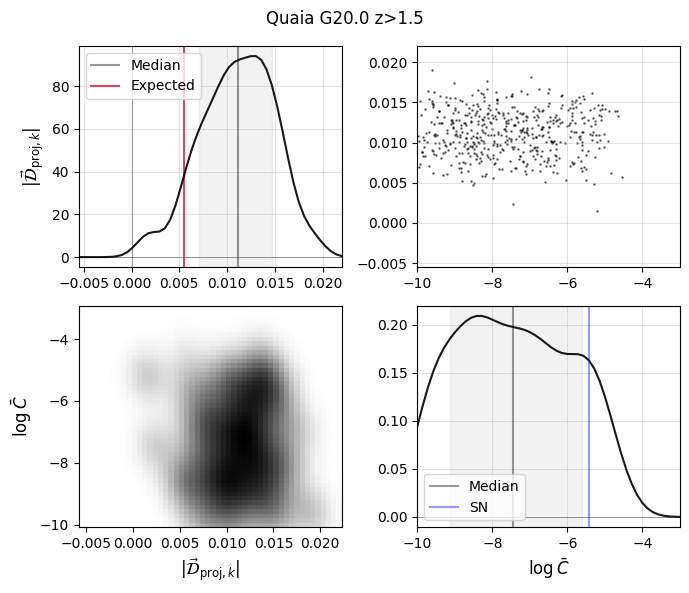

In [43]:
sample_name = 'quaia_G20.0_zsplit2bin1'
q_amp, q_excess, relamp, z, res, axs = get_abc_results_dipole_excess(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_excess_nside{nside}_500mocks_18iters_base-rate-{18.840:.4f}/results.npy'),
                                          title='Quaia G20.0 z>1.5')
axs[1,1].axvline(np.log10(1/Nsources[sample_name]), c='b', alpha=0.4, lw=1.5, label='SN')
axs[1,1].legend()
sample_names.append(sample_name)
quantiles_amp.append(q_amp)
quantiles_excess.append(q_excess)
relamps.append(relamp)
zscores.append(z)

expected dipole_amp = 0.0074
mean dipole_amp = 0.0090
median dipole_amp = 0.0091
std dipole_amp = 0.0022
z score = -0.7775


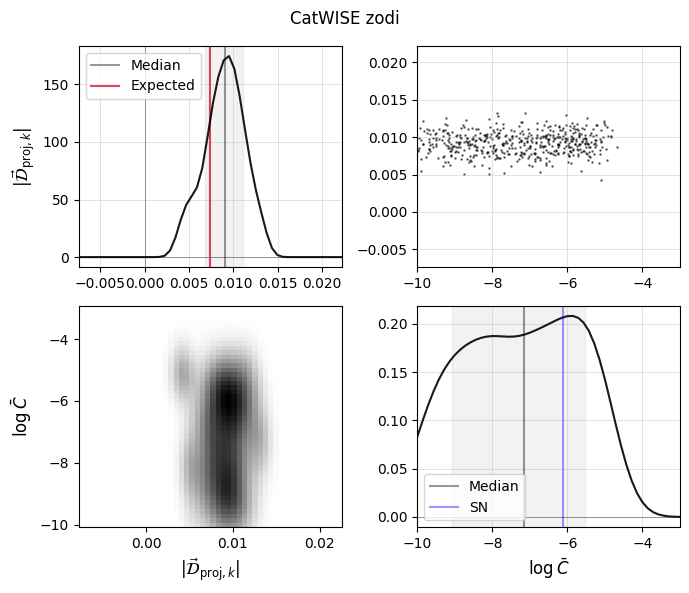

In [44]:
sample_name = 'catwise_zodi'
q_amp, q_excess, relamp, z, res, axs = get_abc_results_dipole_excess(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_excess_nside{nside}_500mocks_18iters_base-rate-{base_rate_catwise:.4f}/results.npy'),
                                          title='CatWISE zodi')
axs[1,1].axvline(np.log10(1/Nsources[sample_name]), c='b', alpha=0.4, lw=1.5, label='SN')
axs[1,1].legend()
sample_names.append(sample_name)
quantiles_amp.append(q_amp)
quantiles_excess.append(q_excess)
relamps.append(relamp)
zscores.append(z)

expected dipole_amp = 0.0074
mean dipole_amp = 0.0122
median dipole_amp = 0.0121
std dipole_amp = 0.0020
z score = -2.3245


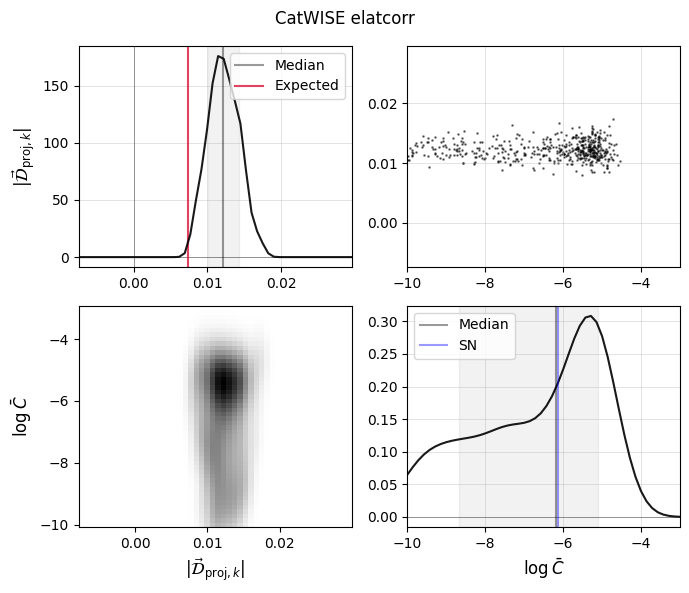

In [45]:
sample_name = 'catwise_elatcorr'
q_amp, q_excess, relamp, z, res, axs = get_abc_results_dipole_excess(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_excess_nside{nside}_500mocks_18iters_base-rate-{base_rate_catwise:.4f}/results.npy'),
                                          title='CatWISE elatcorr')
axs[1,1].axvline(np.log10(1/Nsources[sample_name]), c='b', alpha=0.4, lw=1.5, label='SN')
axs[1,1].legend()
sample_names.append(sample_name)
quantiles_amp.append(q_amp)
quantiles_excess.append(q_excess)
relamps.append(relamp)
zscores.append(z)

In [46]:
print(f"{'sample name:':30}{'dipole posterior:':30}{'log excess posterior:':30}{'relative amplitude:':25}{'z score:'}")
print('=' * 130)
for i, (name, q_dipamp, q_excess, relamp, zscore) in enumerate(zip(sample_names, quantiles_amp, quantiles_excess, relamps, zscores)):
    strs = [
        f'{x[1]:.4f} +{x[2]-x[1]:.4f} -{x[1]-x[0]:.4f}' for x in [q_dipamp, q_excess, relamp]
    ]
    print(f"{name:30}{strs[0]:30}{strs[1]:30}{strs[2]:25}{zscore:.3f}")

sample name:                  dipole posterior:             log excess posterior:         relative amplitude:      z score:
quaia_G20.0_zodi              0.0087 +0.0025 -0.0028        -7.4939 +1.4990 -1.5232       1.6821 +0.4877 -0.5297   -1.376
quaia_G20.0_orig              0.0095 +0.0032 -0.0026        -7.3378 +1.5628 -1.8639       1.8337 +0.6189 -0.5022   -1.704
quaia_G20.5_orig              0.0127 +0.0025 -0.0026        -6.3750 +1.3935 -2.5054       2.7109 +0.5316 -0.5455   -3.066
quaia_G20.0_zsplit2bin0       0.0124 +0.0036 -0.0034        -7.5222 +1.5288 -1.4980       2.4702 +0.7299 -0.6730   -2.221
quaia_G20.0_zsplit2bin1       0.0111 +0.0035 -0.0041        -7.4621 +1.8499 -1.6778       2.0240 +0.6430 -0.7371   -1.489
catwise_zodi                  0.0091 +0.0020 -0.0023        -7.1543 +1.6295 -1.9109       1.2306 +0.2708 -0.3098   -0.778
catwise_elatcorr              0.0121 +0.0022 -0.0020        -6.1801 +1.0730 -2.4985       1.6413 +0.2944 -0.2745   -2.325


In [47]:
# save the relative amplitudes for the summary plot
sample_names_dipole_excess = sample_names
relamps_dipole_excess = relamps

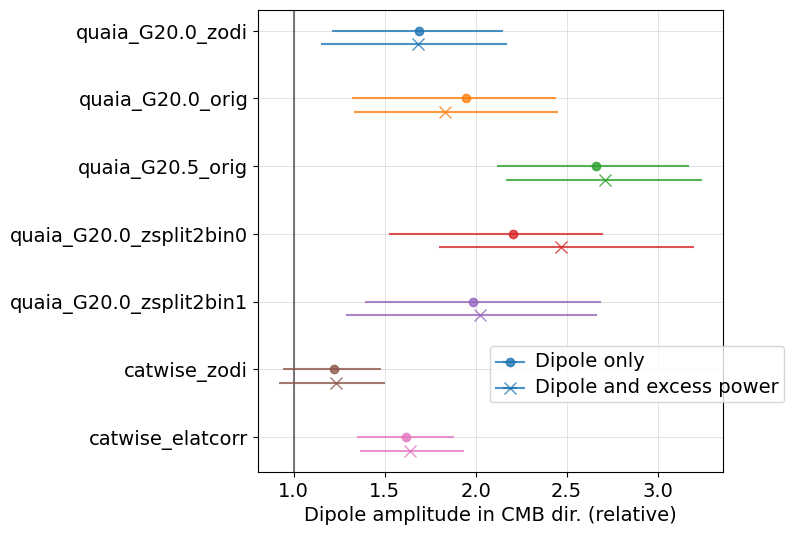

In [48]:
# try out a summary plot:
fig, ax = plt.subplots(figsize=(6,6))
cs = plt.get_cmap('tab10').colors

# get the longest name list (BUG: assumes the other list is a subsample with no unique names)
names = max([sample_names_dipole_only, sample_names_dipole_excess], key=len)
    # list(set(sample_names_dipole_excess).intersection(sample_names_dipole_only))
ylocs = np.arange(len(names))

ax.axvline(1., color='k', alpha=0.5)

for i, (name, relamp) in enumerate(zip(sample_names_dipole_only, relamps_dipole_only)):
    iname = names.index(name)
    label = 'Dipole only' if i == 0 else ''
    err = np.array([relamp[1] - relamp[0], relamp[2] - relamp[1]])[:,np.newaxis]
        # error bars are the difference with the median rather than raw quantiles
    ax.errorbar(relamp[1], ylocs[-(iname+1)], xerr=err, marker='o', alpha=0.8, c=cs[iname], label=label)

for i, (name, relamp) in enumerate(zip(sample_names_dipole_excess, relamps_dipole_excess)):
    iname = names.index(name)
    label = 'Dipole and excess power' if i == 0 else ''
    err = np.array([relamp[1] - relamp[0], relamp[2] - relamp[1]])[:,np.newaxis]
        # error bars are the difference with the median rather than raw quantiles
    ax.errorbar(relamp[1], ylocs[-(iname+1)] - 0.2, xerr=err, marker='x', ms=8, alpha=0.8, c=cs[iname], label=label)

ax.set_yticks(ylocs[::-1], names)
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel('Dipole amplitude in CMB dir. (relative)')
ax.legend(loc=(0.5,0.15))

# update all font sizes in this ax
for text in ax.findobj(match=plt.Text):
    text.set_fontsize(14)

# Quaia: shot noise

In [19]:
nside = 2
res = np.load(os.path.join(resdir, f'ABC/quaia_G20.0_shot-noise_nside{nside}_500mocks_14iters_base-rate-{base_rate_quaia:.4f}/results.npy'),
              allow_pickle=True).item()
history = res['history']
prior = res['prior']
posterior = res['posterior']

# quantiles
df, w = posterior
q_excess = tools.quantile(df['log_excess'], [0.16, 0.5, 0.84], weights=w)

Text(0.5, 0, 'Log excess power')

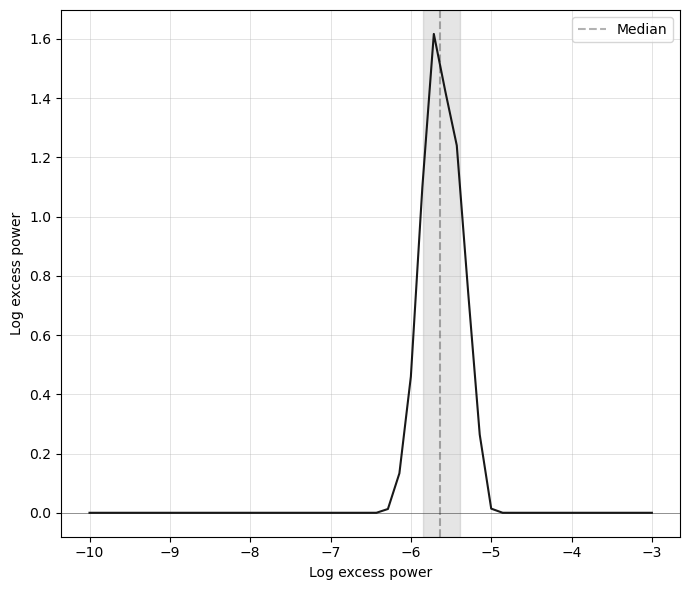

In [20]:
# plot (copied and adjusted from the pyabc.visualization source code)
par_id = [x for x in prior.keys()][0]
fig, ax = plt.subplots(figsize=(7,6), tight_layout=True)
label = 'Log excess power'

df, w = posterior

# quantiles?
q = tools.quantile(df[par_id], [0.16, 0.5, 0.84], weights=w)

# diagonal
x, pdf = tools.get_kde_1d([df, w], prior, par_id)
ax.plot(x, pdf, c='k', alpha=0.9, lw=1.5)
ax.axvline(q[1], c='k', alpha=0.3, ls='--', label='Median')
ax.axvspan(q[0], q[2], color='k', alpha=0.1)
ax.axhline(0., c='k', alpha=0.5, lw=0.5)
# ax.axvline(0.0052, c='k', alpha=0.3, lw=1.5, label='Expected')
ax.legend()
ax.grid(alpha=0.5, lw=0.5)

ax.set_ylabel(label)
ax.set_xlabel(label)

In [21]:
print(f"Quaia G<20.0 posterior:\tlog excess:\t{q[1]:.4f} +{q[2]-q[1]:.4f} -{q[1]-q[0]:.4f}")

Quaia G<20.0 posterior:	log excess:	-5.6355 +0.2456 -0.2176


In [22]:
10**q[1]

2.3147699118553776e-06

In [37]:
1/32000

3.125e-05

Interesting... other methods to estimate shot noise in Quaia give more like ~8e-6...
Why is this lower?
Is this possibly a base rate issue?

#### `quaia_G20.0_orig`

In [14]:
nside = 1
res = np.load(os.path.join(resdir, f'ABC/quaia_G20.0_dipole_excess_nside{nside}_500mocks_20iters_base-rate-{base_rate_quaia:.4f}',
                           'log_excess_bounds_-7-4/results.npy'),
              allow_pickle=True).item()
history = res['history']
prior = res['prior']
posterior = res['posterior']
selfunc = res['selfunc']

# quantiles
df, w = posterior
q_dipamp = tools.quantile(df['dipole_amp'], [0.16, 0.5, 0.84], weights=w)
q_excess = tools.quantile(df['log_excess'], [0.16, 0.5, 0.84], weights=w)

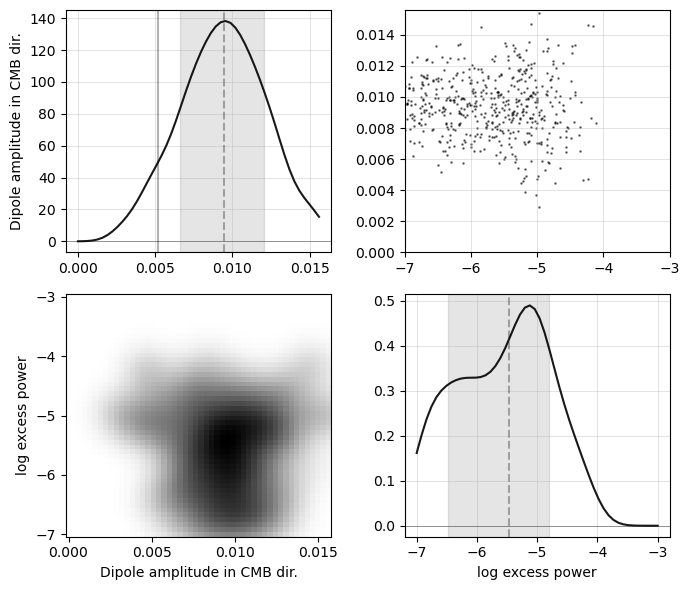

In [15]:
# plot (copied and adjusted from the pyabc.visualization source code)
par_ids = [x for x in prior.keys()]
fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(7,6), tight_layout=True)
labels = ['Dipole amplitude in CMB dir.', 'log excess power']

df, w = posterior

for i, par_id in enumerate(par_ids):

    # quantiles?
    q = tools.quantile(df[par_id], [0.16, 0.5, 0.84], weights=w)

    # diagonal
    ax = axs[i, i]
    x, pdf = tools.get_kde_1d([df, w], prior, par_id)
    ax.plot(x, pdf, c='k', alpha=0.9, lw=1.5)
    ax.axvline(q[1], c='k', alpha=0.3, ls='--')
    ax.axvspan(q[0], q[2], color='k', alpha=0.1)
    ax.axhline(0., c='k', alpha=0.5, lw=0.5)
    if par_id == 'dipole_amp':
        ax.axvline(0.0052, c='k', alpha=0.3, lw=1.5)
    ax.grid(alpha=0.5, lw=0.5)

    axs[i,0].set_ylabel(labels[i])
    axs[len(par_ids)-1,i].set_xlabel(labels[i])
    # axs[i,0].set_xticks(np.linspace(0., 0.02, 5))

    for j in range(0, i):

        # lower
        ax = axs[i, j]
        x, y, pdf = tools.get_kde_2d([df, w], prior, par_ids[j], par_id)
        mesh = ax.pcolormesh(x, y, pdf, shading='auto', cmap='binary')

        # upper
        ax = axs[j, i]
        tools.scatter([df, w], prior, par_id, par_ids[j], ax, color='k', alpha=0.5, marker='.', s=3)
        ax.grid(alpha=0.5, lw=0.5)

##### look at the maps

In [14]:
# load corrected and/or smoothed mean posterior mock
nmocks = 500
mean_mock = np.load(os.path.join(resdir, f'ABC/quaia_dipole_excess_nside{nside}_{nmocks}mocks_20iters_base-rate-33.6330/accepted_samples/mean_mock.npy'))
mean_mock_smoothed = np.load(os.path.join(resdir, f'ABC/quaia_dipole_excess_nside{nside}_{nmocks}mocks_20iters_base-rate-33.6330/accepted_samples/mean_mock_smoothed.npy'))
mean_mock_corr = np.load(os.path.join(resdir, f'ABC/quaia_dipole_excess_nside{nside}_{nmocks}mocks_20iters_base-rate-33.6330/accepted_samples/mean_mock_corr.npy'))
mean_mock_corr_smoothed = np.load(os.path.join(resdir, f'ABC/quaia_dipole_excess_nside{nside}_{nmocks}mocks_20iters_base-rate-33.6330/accepted_samples/mean_mock_corr_smoothed.npy'))

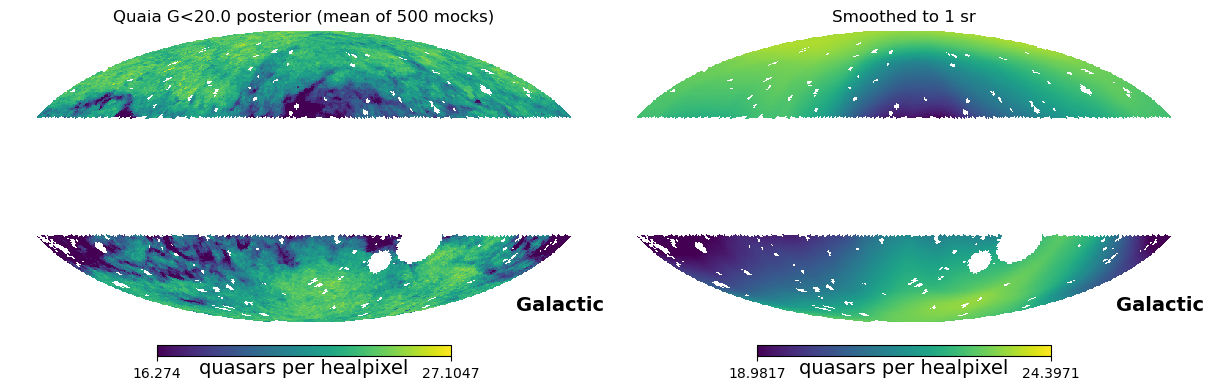

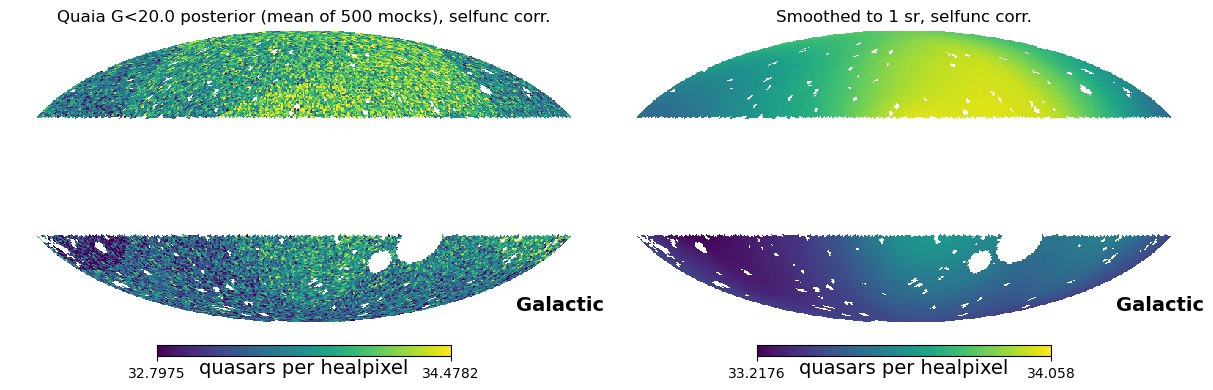

In [15]:
# plot
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='viridis', unit='quasars per healpixel', fig=fig, badcolor='w')
mean, std = np.nanmean(mean_mock), np.nanstd(mean_mock)
hp.mollview(mean_mock, min=mean-2*std, max=mean+2*std, title=f'Quaia G<20.0 posterior (mean of {nmocks} mocks)', sub=(1,2,1), **kwargs)
hp.mollview(mean_mock_smoothed, min=mean-std, max=mean+std, title='Smoothed to 1 sr', sub=(1,2,2), **kwargs)

# plot
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='viridis', unit='quasars per healpixel', fig=fig, badcolor='w')
mean, std = np.nanmean(mean_mock_corr), np.nanstd(mean_mock_corr)
hp.mollview(mean_mock_corr, min=mean-2*std, max=mean+2*std, title=f'Quaia G<20.0 posterior (mean of {nmocks} mocks), selfunc corr.', sub=(1,2,1), **kwargs)
hp.mollview(mean_mock_corr_smoothed, min=mean-std, max=mean+std, title='Smoothed to 1 sr, selfunc corr.', sub=(1,2,2), **kwargs)

In [16]:
# overdensities

# unsmoothed:
odmap_quaia = quaia_qmap / np.nanmean(quaia_qmap)- 1
odmap_mock = mean_mock / np.nanmean(mean_mock) - 1
odmap_quaia_corr = quaia_qmap_corr / np.nanmean(quaia_qmap_corr) - 1
odmap_mock_corr = mean_mock_corr / np.nanmean(mean_mock_corr) - 1

# smoothed:
odmap_quaia_smoothed = quaia_qmap_smoothed / np.nanmean(quaia_qmap_smoothed) - 1
odmap_mock_smoothed = mean_mock_smoothed / np.nanmean(mean_mock_smoothed) - 1
odmap_quaia_corr_smoothed = quaia_qmap_corr_smoothed / np.nanmean(quaia_qmap_corr_smoothed) - 1
odmap_mock_corr_smoothed = mean_mock_corr_smoothed / np.nanmean(mean_mock_corr_smoothed) - 1

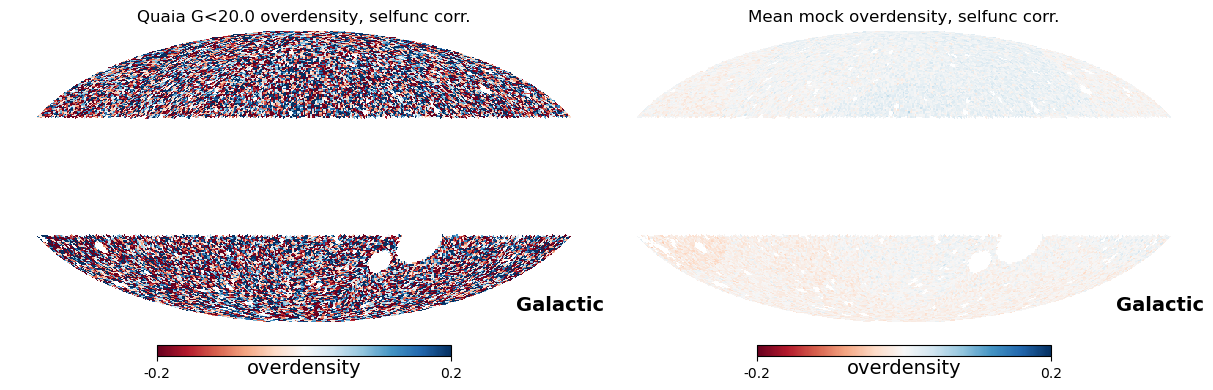

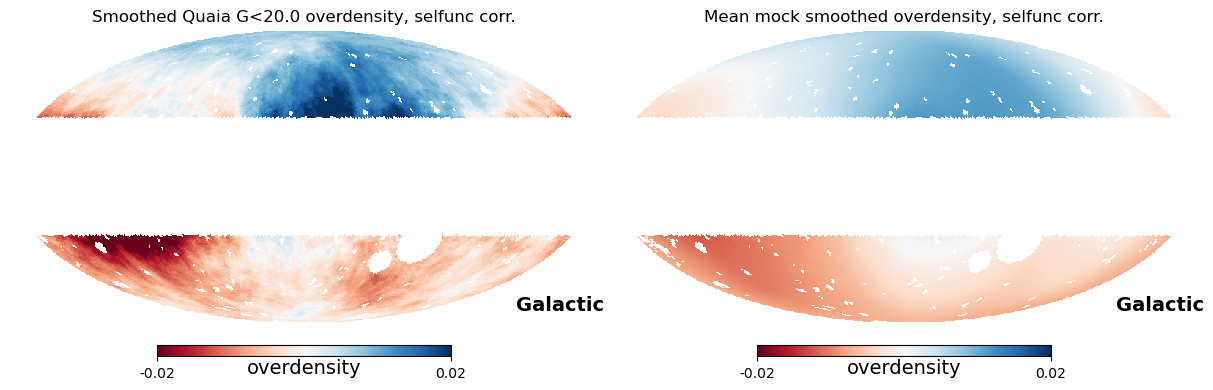

In [17]:
# plot
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='RdBu', unit='overdensity', fig=fig, badcolor='w', min=-0.2, max=0.2)
hp.mollview(odmap_quaia_corr, title=f'Quaia G<20.0 overdensity, selfunc corr.', sub=(1,2,1), **kwargs)
hp.mollview(odmap_mock_corr, title='Mean mock overdensity, selfunc corr.', sub=(1,2,2), **kwargs)

# plot
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='RdBu', unit='overdensity', fig=fig, badcolor='w', min=-0.02, max=0.02)
hp.mollview(odmap_quaia_corr_smoothed, title=f'Smoothed Quaia G<20.0 overdensity, selfunc corr.', sub=(1,2,1), **kwargs)
hp.mollview(odmap_mock_corr_smoothed, title='Mean mock smoothed overdensity, selfunc corr.', sub=(1,2,2), **kwargs)

We easily see the dipole in the mocks, like we want! The other angular power averages out since only the kinematic dipole direction is fixed.

**Actually I'm realizing this is actually a fairly big "find", since given our discussions around the fake data tests, we've seen that the dipole amplitude is free to be positive or negative, so as far as the model is concerned, the dipole is free to be in the opposite direction if that best fits the data, but it doesn't!

In [20]:
# residuals! with selfunc-corrected map
res = odmap_mock_corr - odmap_quaia_corr
res_smoothed = tools.smooth_map(res, sr=1)

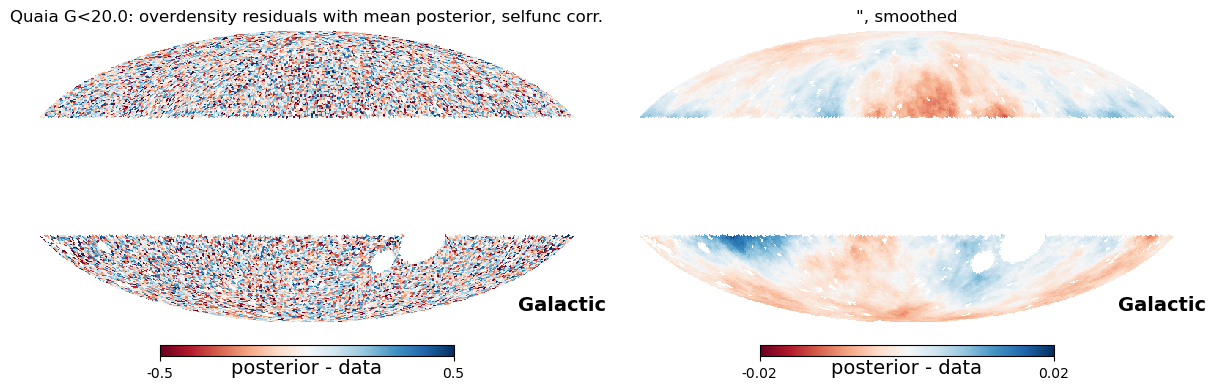

In [21]:
# residuals!
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='RdBu', unit='posterior - data', fig=fig, badcolor='w')
hp.mollview(res, min=-0.5, max=0.5, title='Quaia G<20.0: overdensity residuals with mean posterior, selfunc corr.', sub=(1,2,1), **kwargs)
hp.mollview(res_smoothed, min=-.02, max=.02, title='", smoothed', sub=(1,2,2), **kwargs)

#### `quaia_G20.0_zodi`

In [16]:
nside = 1
res = np.load(os.path.join(resdir, f'ABC/quaia_G20.0_zodi_dipole_excess_nside{nside}_500mocks_18iters_base-rate-{base_rate_quaia:.4f}/results.npy'),
              allow_pickle=True).item()
history_z = res['history']
prior_z = res['prior']
posterior_z = res['posterior']
selfunc_z = res['selfunc']

# quantiles
df, w = posterior_z
q_dipamp_z = tools.quantile(df['dipole_amp'], [0.16, 0.5, 0.84], weights=w)
q_excess_z = tools.quantile(df['log_excess'], [0.16, 0.5, 0.84], weights=w)

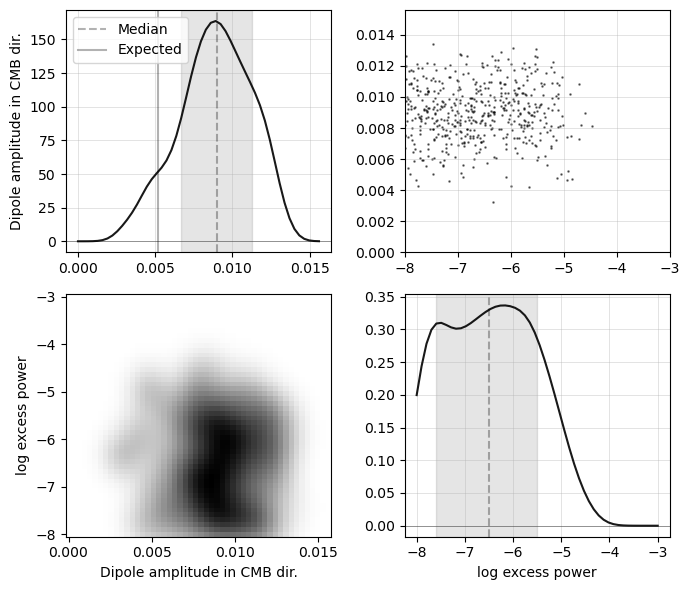

In [17]:
# plot (copied and adjusted from the pyabc.visualization source code)
par_ids = [x for x in prior_z.keys()]
fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(7,6), tight_layout=True)
labels = ['Dipole amplitude in CMB dir.', 'log excess power']

df, w = posterior_z

for i, par_id in enumerate(par_ids):

    # quantiles?
    q = tools.quantile(df[par_id], [0.16, 0.5, 0.84], weights=w)

    # diagonal
    ax = axs[i, i]
    x, pdf = tools.get_kde_1d([df, w], prior_z, par_id)
    ax.plot(x, pdf, c='k', alpha=0.9, lw=1.5)
    ax.axvline(q[1], c='k', alpha=0.3, ls='--', label='Median')
    ax.axvspan(q[0], q[2], color='k', alpha=0.1)
    ax.axhline(0., c='k', alpha=0.5, lw=0.5)
    if par_id == 'dipole_amp':
        ax.axvline(0.0052, c='k', alpha=0.3, lw=1.5, label='Expected')
        ax.legend()
    ax.grid(alpha=0.5, lw=0.5)

    axs[i,0].set_ylabel(labels[i])
    axs[len(par_ids)-1,i].set_xlabel(labels[i])
    # axs[i,0].set_xticks(np.linspace(0., 0.02, 5))

    for j in range(0, i):

        # lower
        ax = axs[i, j]
        x, y, pdf = tools.get_kde_2d([df, w], prior_z, par_ids[j], par_id)
        mesh = ax.pcolormesh(x, y, pdf, shading='auto', cmap='binary')

        # upper
        ax = axs[j, i]
        tools.scatter([df, w], prior_z, par_id, par_ids[j], ax, color='k', alpha=0.5, marker='.', s=3)
        ax.grid(alpha=0.5, lw=0.5)

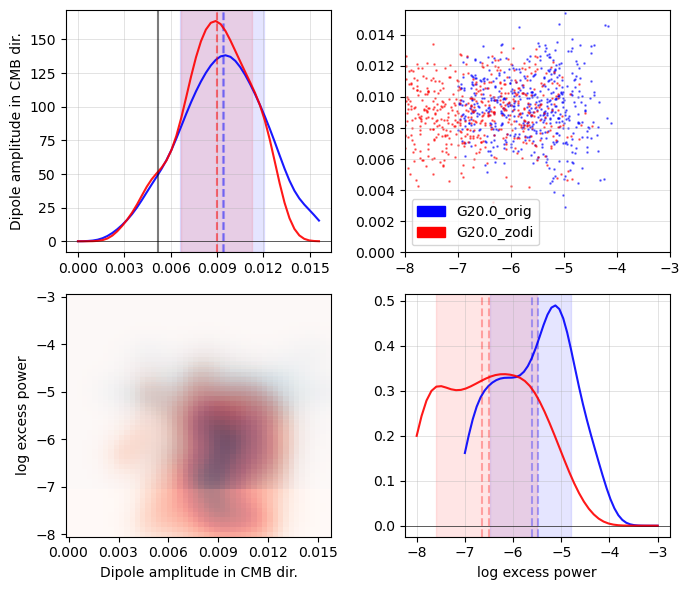

In [18]:
# plot (copied and adjusted from the pyabc.visualization source code)
par_ids = [x for x in prior.keys()]
fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(7,6), tight_layout=True)
labels = ['Dipole amplitude in CMB dir.', 'log excess power']
cs = ['b', 'r']
cmaps = ['Blues', 'Reds']

orig_patch = mpl.patches.Patch(color=cs[0], label=r'G20.0_orig')
zodi_patch = mpl.patches.Patch(color=cs[1], label=r'G20.0_zodi')

priors = [prior, prior_z]

for k, (df, w) in enumerate([posterior, posterior_z]):

    for i, par_id in enumerate(par_ids):

        # quantiles?
        q = tools.quantile(df[par_id], [0.16, 0.5, 0.84], weights=w)
    
        # diagonal
        ax = axs[i, i]
        x, pdf = tools.get_kde_1d([df, w], priors[k], par_id)
        ax.plot(x, pdf, c=cs[k], alpha=.9, lw=1.5)
        ax.axvline(np.median(df[par_id]), c=cs[k], alpha=0.3, ls='--')
        ax.axvline(q[1], c=cs[k], alpha=0.3, ls='--')
        ax.axvspan(q[0], q[2], color=cs[k], alpha=0.1)
        ax.axhline(0., c='k', alpha=0.5, lw=0.5)
        if par_id == 'dipole_amp':
            ax.axvline(0.0052, c='k', alpha=0.3, lw=1.5)
        ax.grid(alpha=0.5, lw=0.5)
        # ax.axvline(data_pars[par_id], c='royalblue', alpha=0.7)
    
        axs[i,0].set_ylabel(labels[i])
        axs[len(par_ids)-1,i].set_xlabel(labels[i])
        axs[i,0].set_xticks(np.linspace(0., 0.015, 6))
    
        for j in range(0, i):
    
            # lower
            ax = axs[i, j]
            x, y, pdf = tools.get_kde_2d([df, w], priors[k], par_ids[j], par_id)
            mesh = ax.pcolormesh(x, y, pdf, shading='auto', cmap=cmaps[k], alpha=0.5)
    
            # upper
            ax = axs[j, i]
            tools.scatter([df, w], priors[k], par_id, par_ids[j], ax, color=cs[k], alpha=0.5, marker='.', s=3)
            ax.grid(alpha=0.5, lw=0.5)
        
    # fig.suptitle(f'Quaia ABC posteriors, nside={nside}, {history.max_t} generations')

ax.legend(handles=[orig_patch, zodi_patch])

In [19]:
print(f"{'Quaia catalog:':30}{'dipole posterior:':30}{'log excess posterior:':30}{'relative amplitude'}")
q_dipamp_strs = [
    f'{q[1]:.4f} +{q[2]-q[1]:.4f} -{q[1]-q[0]:.4f}' for q in [q_dipamp, q_dipamp_z]
]
q_excess_strs = [
    f'{q[1]:.4f} +{q[2]-q[1]:.4f} -{q[1]-q[0]:.4f}' for q in [q_excess, q_excess_z]
]
relamp_strs = [
    f'{q[1] / 0.0052:.2f}' for q in [q_dipamp, q_dipamp_z]
]
print('=' * 110)
labels = ['G20.0_orig', 'G20.0_zodi']
assert len(labels) == len(q_dipamp_strs) == len(q_excess_strs)
for i, label in enumerate(labels):
    print(f"{label:30}{q_dipamp_strs[i]:30}{q_excess_strs[i]:30}{relamp_strs[i]}")

Quaia catalog:                dipole posterior:             log excess posterior:         relative amplitude
G20.0_orig                    0.0094 +0.0026 -0.0028        -5.4741 +0.6774 -1.0055       1.81
G20.0_zodi                    0.0090 +0.0023 -0.0024        -6.5005 +0.9889 -1.0925       1.73


##### look at the maps

In [15]:
# posterior mocks
nmocks = 500
mean_mock = np.zeros_like(quaia_qmap)
for i in range(nmocks):
    mock = np.load(os.path.join(resdir, f'ABC/quaia_G20.0_zodi_dipole_excess_nside{nside}_500mocks_18iters_base-rate-{base_rate_quaia:.4f}',
                                'accepted_samples', f'mock{i}.npy')).astype(float)
    mock[mock == 0.] = np.nan
    mean_mock += mock
mean_mock /= nmocks

In [16]:
# smooth
mean_mock_smoothed = tools.smooth_map(mean_mock, sr=1)
# correct by the selection function
mean_mock_corr = mean_mock / selfunc_quaia_zodi
mean_mock_corr_smoothed = tools.smooth_map(mean_mock_corr, sr=1)

In [17]:
# save
np.save(os.path.join(resdir, f'ABC/quaia_G20.0_zodi_dipole_excess_nside{nside}_500mocks_18iters_base-rate-{base_rate_quaia:.4f}/accepted_samples/mean_mock.npy'), mean_mock)
np.save(os.path.join(resdir, f'ABC/quaia_G20.0_zodi_dipole_excess_nside{nside}_500mocks_18iters_base-rate-{base_rate_quaia:.4f}/accepted_samples/mean_mock_corr.npy'), mean_mock_corr)
np.save(os.path.join(resdir, f'ABC/quaia_G20.0_zodi_dipole_excess_nside{nside}_500mocks_18iters_base-rate-{base_rate_quaia:.4f}/accepted_samples/mean_mock_smoothed.npy'), mean_mock_smoothed)
np.save(os.path.join(resdir, f'ABC/quaia_G20.0_zodi_dipole_excess_nside{nside}_500mocks_18iters_base-rate-{base_rate_quaia:.4f}/accepted_samples/mean_mock_corr_smoothed.npy'), mean_mock_corr_smoothed)

In [18]:
# load
nmocks = 500
mean_mock = np.load(os.path.join(resdir, f'ABC/quaia_G20.0_zodi_dipole_excess_nside{nside}_500mocks_18iters_base-rate-{base_rate_quaia:.4f}/accepted_samples/mean_mock.npy'))
mean_mock_smoothed = np.load(os.path.join(resdir, f'ABC/quaia_G20.0_zodi_dipole_excess_nside{nside}_500mocks_18iters_base-rate-{base_rate_quaia:.4f}/accepted_samples/mean_mock_smoothed.npy'))
mean_mock_corr = np.load(os.path.join(resdir, f'ABC/quaia_G20.0_zodi_dipole_excess_nside{nside}_500mocks_18iters_base-rate-{base_rate_quaia:.4f}/accepted_samples/mean_mock_corr.npy'))
mean_mock_corr_smoothed = np.load(os.path.join(resdir, f'ABC/quaia_G20.0_zodi_dipole_excess_nside{nside}_500mocks_18iters_base-rate-{base_rate_quaia:.4f}/accepted_samples/mean_mock_corr_smoothed.npy'))

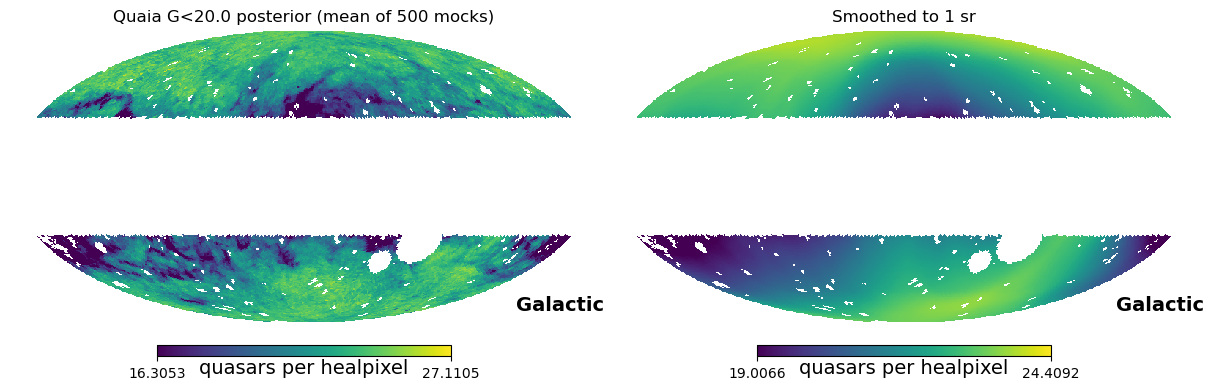

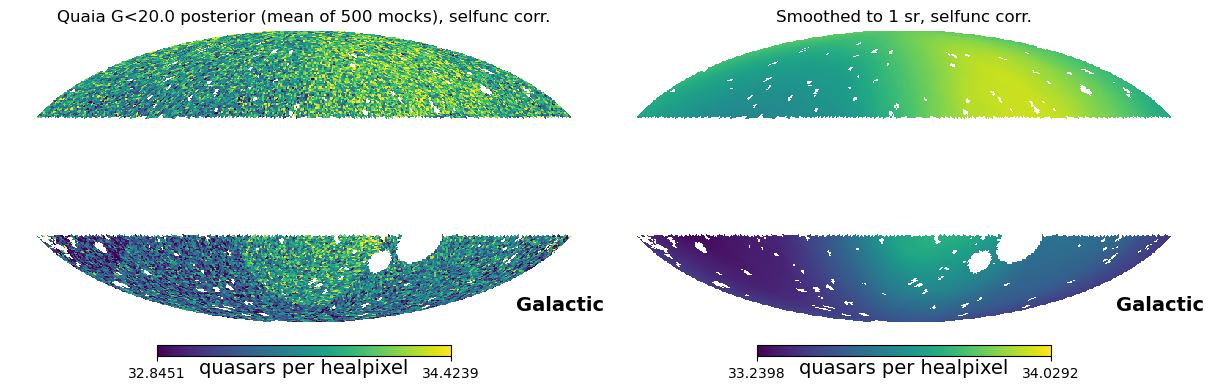

In [19]:
# plot
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='viridis', unit='quasars per healpixel', fig=fig, badcolor='w')
mean, std = np.nanmean(mean_mock), np.nanstd(mean_mock)
hp.mollview(mean_mock, min=mean-2*std, max=mean+2*std, title=f'Quaia G<20.0 posterior (mean of {nmocks} mocks)', sub=(1,2,1), **kwargs)
hp.mollview(mean_mock_smoothed, min=mean-std, max=mean+std, title='Smoothed to 1 sr', sub=(1,2,2), **kwargs)

# plot
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='viridis', unit='quasars per healpixel', fig=fig, badcolor='w')
mean, std = np.nanmean(mean_mock_corr), np.nanstd(mean_mock_corr)
hp.mollview(mean_mock_corr, min=mean-2*std, max=mean+2*std, title=f'Quaia G<20.0 posterior (mean of {nmocks} mocks), selfunc corr.', sub=(1,2,1), **kwargs)
hp.mollview(mean_mock_corr_smoothed, min=mean-std, max=mean+std, title='Smoothed to 1 sr, selfunc corr.', sub=(1,2,2), **kwargs)

In [34]:
# posterior mocks
nmocks = 500
mean_mock = np.zeros_like(catwise_qmap)
for i in range(nmocks):
    mock = np.load(os.path.join(resdir, 'ABC/catwise_dipole_excess_nside1_500mocks_20iters_base-rate-77.4495/accepted_samples',
                                f'mock{i}.npy')).astype(float)
    mock[mock == 0.] = np.nan
    mean_mock += mock
mean_mock /= nmocks

In [35]:
# smooth
mean_mock_smoothed = tools.smooth_map(mean_mock, sr=1)
# correct by the selection function
mean_mock_corr = mean_mock / selfunc_catwise
mean_mock_corr_smoothed = tools.smooth_map(mean_mock_corr, sr=1)

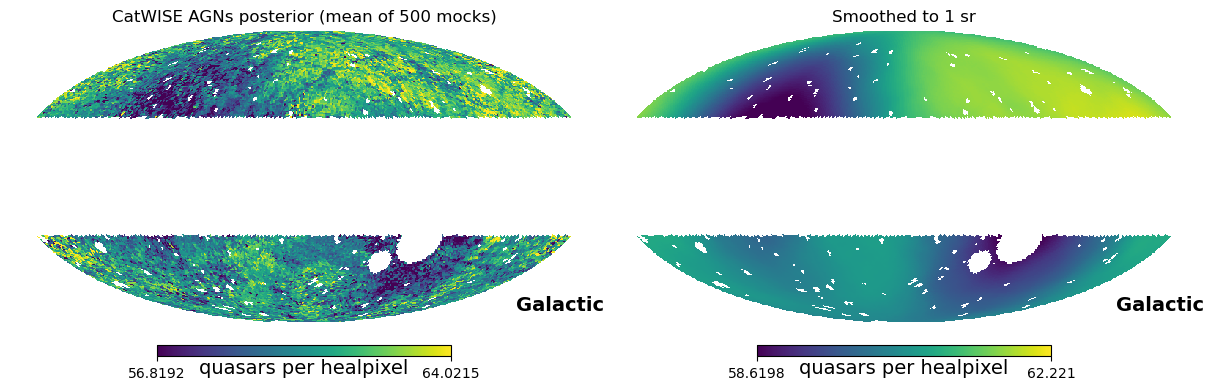

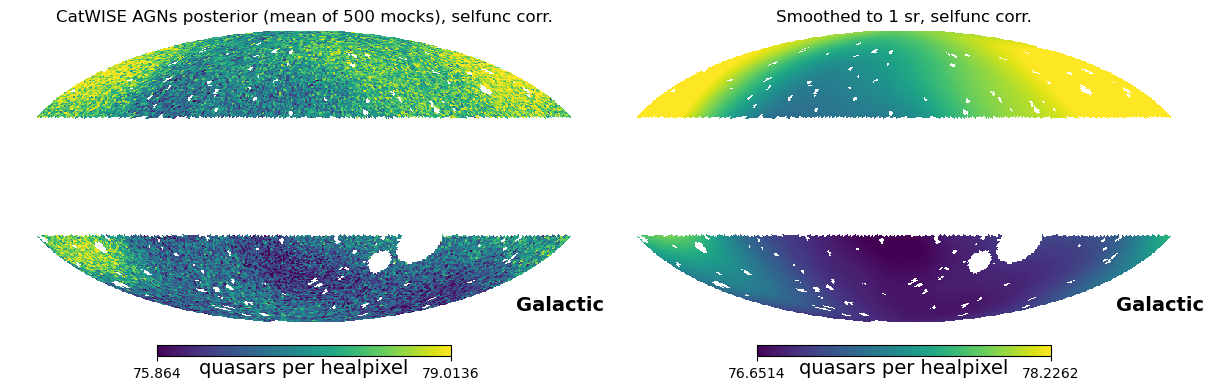

In [36]:
# plot
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='viridis', unit='quasars per healpixel', fig=fig, badcolor='w')
mean, std = np.nanmean(mean_mock), np.nanstd(mean_mock)
hp.mollview(mean_mock, min=mean-2*std, max=mean+2*std, title=f'CatWISE AGNs posterior (mean of {nmocks} mocks)', sub=(1,2,1), **kwargs)
hp.mollview(mean_mock_smoothed, min=mean-std, max=mean+std, title='Smoothed to 1 sr', sub=(1,2,2), **kwargs)

# plot
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='viridis', unit='quasars per healpixel', fig=fig, badcolor='w')
mean, std = np.nanmean(mean_mock_corr), np.nanstd(mean_mock_corr)
hp.mollview(mean_mock_corr, min=mean-2*std, max=mean+2*std, title=f'CatWISE AGNs posterior (mean of {nmocks} mocks), selfunc corr.', sub=(1,2,1), **kwargs)
hp.mollview(mean_mock_corr_smoothed, min=mean-std, max=mean+std, title='Smoothed to 1 sr, selfunc corr.', sub=(1,2,2), **kwargs)

In [37]:
# overdensities
odmap_catwise = catwise_qmap_smoothed / np.nanmean(catwise_qmap_smoothed) - 1
odmap_mock = mean_mock_smoothed / np.nanmean(mean_mock_smoothed) - 1

# and the selfunc corrected
odmap_catwise_corr = catwise_qmap_corr_smoothed / np.nanmean(catwise_qmap_corr_smoothed) - 1
odmap_mock_corr = mean_mock_corr_smoothed / np.nanmean(mean_mock_corr_smoothed) - 1

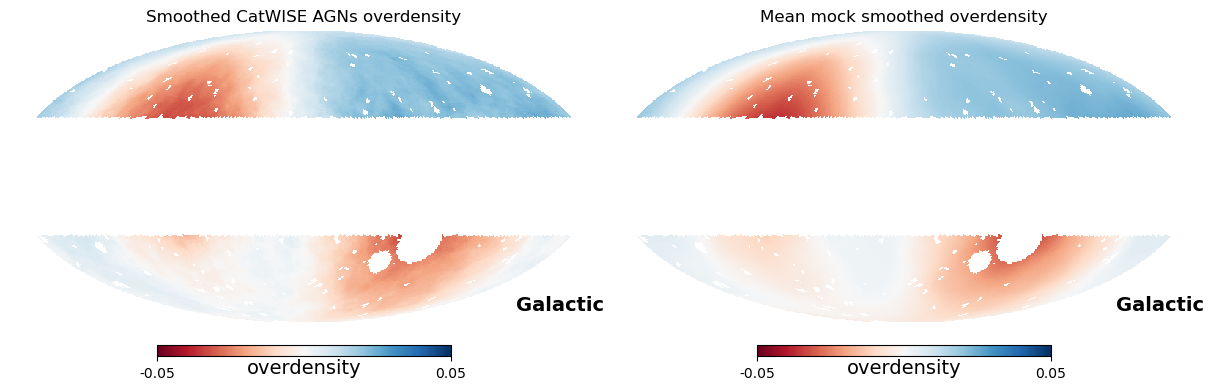

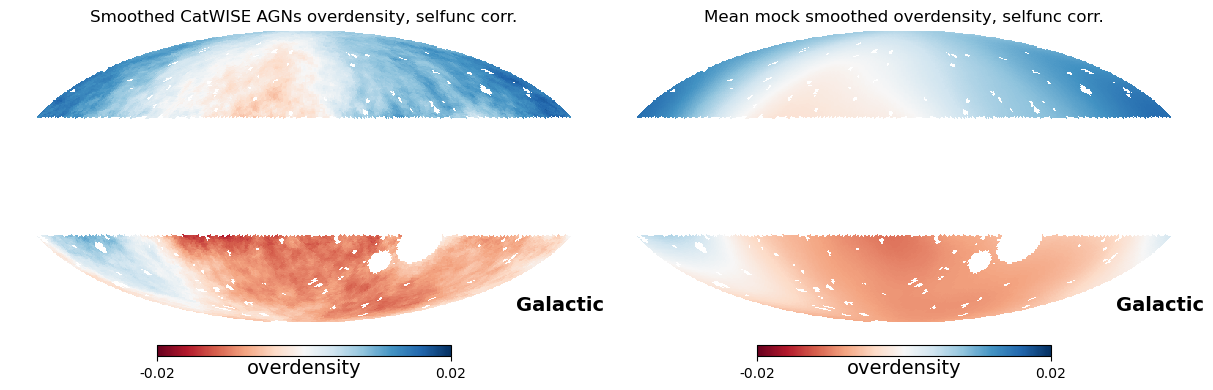

In [39]:
# plot
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='RdBu', unit='overdensity', fig=fig, badcolor='w', min=-0.05, max=0.05)
hp.mollview(odmap_catwise, title=f'Smoothed CatWISE AGNs overdensity', sub=(1,2,1), **kwargs)
hp.mollview(odmap_mock, title='Mean mock smoothed overdensity', sub=(1,2,2), **kwargs)

# plot
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='RdBu', unit='overdensity', fig=fig, badcolor='w', min=-0.02, max=0.02)
hp.mollview(odmap_catwise_corr, title=f'Smoothed CatWISE AGNs overdensity, selfunc corr.', sub=(1,2,1), **kwargs)
hp.mollview(odmap_mock_corr, title='Mean mock smoothed overdensity, selfunc corr.', sub=(1,2,2), **kwargs)

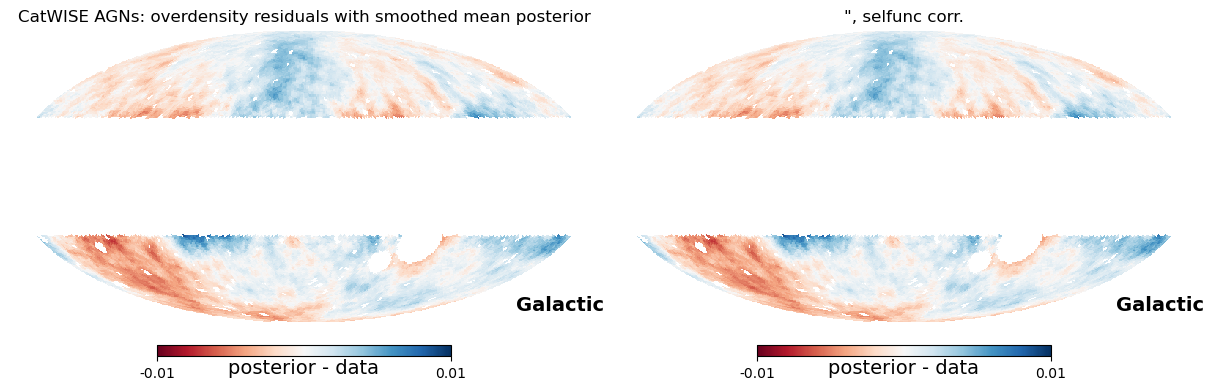

In [42]:
# residuals!
fig = plt.figure(figsize=(12,4))
res = odmap_mock - odmap_catwise
res_corr = odmap_mock_corr - odmap_catwise_corr
kwargs = dict(coord=['C','G'], cmap='RdBu', unit='posterior - data', fig=fig, badcolor='w')
hp.mollview(res, min=-.01, max=.01, title='CatWISE AGNs: overdensity residuals with smoothed mean posterior', sub=(1,2,1), **kwargs)
hp.mollview(res_corr, min=-.01, max=.01, title='", selfunc corr.', sub=(1,2,2), **kwargs)

In [37]:
# load posterior results and take mean
mock_Cells = []
for i in range(nmocks):
    Cells_res = np.load(os.path.join(resdir, f'ABC/catwise_dipole_excess_nside1_500mocks_20iters_base-rate-77.4495/accepted_samples_Cells',
                                     f'Cells_mock{i}.npy'), allow_pickle=True).item()
    assert np.all(Cells_res['ells'] == ells)
    mock_Cells.append(Cells_res['Cells'])
mean_Cells_mock = np.mean(np.array(mock_Cells), axis=0)
std_Cells_mock = np.std(np.array(mock_Cells), axis=0)

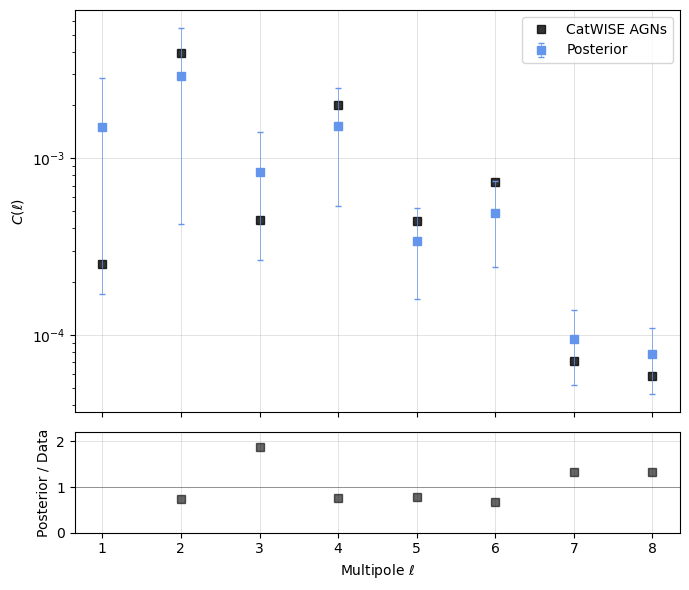

In [38]:
fig = plt.figure(figsize=(7,6), tight_layout=True)

gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[1., 0.25])

ax0 = fig.add_subplot(gs[0])
kwargs = dict(marker='s', ls='None')
ax0.plot(ells[1:], Cells[1:], c='k', alpha=0.8, label='CatWISE AGNs', **kwargs)
ax0.errorbar(ells[1:], mean_Cells_mock[1:], yerr=std_Cells_mock[1:], capsize=2, lw=0.5, c='cornflowerblue',
            label='Posterior', **kwargs)
ax0.set_ylabel(r'$C(\ell)$')
ax0.legend()
ax0.semilogy()
ax0.set_xticklabels([])

ax1 = fig.add_subplot(gs[1])
ax1.plot(ells[1:], mean_Cells_mock[1:] / Cells[1:], c='k', alpha=0.6, **kwargs)
ax1.set_xlabel(r'Multipole $\ell$')
ax1.axhline(1., c='k', alpha=0.5, lw=0.5)
ax1.set_ylim(0., 2.2)
ax1.set_ylabel('Posterior / Data')

for ax in (ax0, ax1):
    ax.grid(alpha=0.5, lw=0.5)